#### Imports

In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import json
from os.path import isfile
from opendatasets import download_kaggle_dataset

from random import randint
from collections import defaultdict
import ipaddress as ip
import re
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

In [2]:
# # You may need to install opendatasets
# !pip install opendatasets

In [3]:
# !pip install xgboost

# Machine learning course project

## Predict if the Merchant is Fraudster

### Author: Georgi Datskov
Softuni username: Datskov

E-mail: g.datskov@gmail.com

### Short problem description: Predict if the Merchant is Fraudster or not for an e-commerce client
#### Dataset owner problem description:
‘XYZ’ is a large e-commerce company with its operations in several countries. As the online giant grows, so has
the number of fraudster merchants are. They deliver counterfeits or, in some cases, nothing at all. Such
schemes leave customers duped, and place both legitimate merchants and the company itself in a constant
battle to rid the marketplace of scammers. Determining this is also important in budgeting for fraud
investigation. It's a well-known problem both to the company and to merchants, which they say hasn't
effectively addressed the issue. They are serious about it and want to protect themselves from these fraudulent
merchants using technology.
You are expected to create an analytical and modelling framework to predict the Merchant Fraudulency(yes/no)
based on the quantitative and qualitative features provided in the dataset while answering other questions too
cited below.

II.The datasets are provided as cited below:

Target attribute: "fraudster" (yes – 1, no – 0)

Train:

• trainmerchantdata.csv : Merchant Information

• trainorderdata.csv : Order Information

• train.csv : Target Label Information

Test:

• testmerchantdata.csv : Merchant Information

• testorderdata.csv : Order Information

• test.csv : Target is not available as it is to be predicted

• ipboundariescountries.csv : IP addresses boundaries for each country

(common for both train and test)

All Attributes names are self-explanatory.

III.Tasks:

Model Building:

You are expected to create an analytical and modelling framework to predict the Merchant Fraudulency based
on the quantitative and qualitative features provided in the datasets. You may derive new features from the
existing features and also from the domain knowledge, which may help in improving the model efficiency.

Visualization Tasks:
Exploratory Data Analysis using visualizations in R Notebook or Jupiter notebook format. (all train data to be
used for this task)

• List down the insights/patterns observed from the visualizations

• Explain the impact of most important attributes on target attribute observed from the
visualizations.

Observations:

Is there any overfitting or underfitting problem? If yes, how do you address it?

IV. Evaluation Metric:

• Consider ‘F1-score’ of the fraudulent class as the error metric for classification task to tune the

model and for submissions in the tool.

V. Hints

Both Python and R provides functions to convert IP string to numeric format which makes the number
comparison easier.

#### Dataset and problem source: Kaggle
https://www.kaggle.com/datasets/girishvutukuri/predict-if-the-merchant-is-fraudster

## Dataset EDA

### Loading the main training datasets and looking around

In [4]:
download_kaggle_dataset('https://www.kaggle.com/datasets/girishvutukuri/predict-if-the-merchant-is-fraudster', './data')

Skipping, found downloaded files in "./data\predict-if-the-merchant-is-fraudster" (use force=True to force download)


In [5]:
merchant_dataset_train = pd.read_csv('data/predict-if-the-merchant-is-fraudster/train_merchant_data-1561627820784.csv')
merchant_dataset_train

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54208                1746213       222372        2018-05-01 21:58:19   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address  
0            VATQMMZTVOZUT      F   39   48.151.136.76  
1            LJCILLBRQZNKS      M   35    94.9.145.169  
2            JFVHSUGKDAYZV      F   40   58.94.157.121  
3            WFRXMPLQYXRMY      M   37  193.187.41.186  
4            GGHKWMSWHCMID      F   27   125.96.20.172  
...                    ...    ...  ...             ...  
54208        KGVMENGCIAVOK      M   43   247.25.244.31  
54209        QJGPOYDONTYCN      M   41   80.30.170.122  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179  

[54213 rows x 7 columns]

In [6]:
order_dataset_train = pd.read_csv('data/predict-if-the-merchant-is-fraudster/train_order_data-1561627847149.csv')
order_dataset_train

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
0           126221  37cea9512f8d  2018-04-29 16:39:26              148   
1           115471  09f12e6efde2  2018-06-16 17:05:40              145   
2           151786  4e69e956e159  2018-10-26 18:00:46               62   
3           140456  663443aaeb82  2018-12-12 05:41:52               28   
4           114721  99258810c121  2018-09-20 11:06:10               70   
...            ...           ...                  ...              ...   
54208       143943  4b0857877884  2018-06-01 14:39:47               90   
54209       125429  2de2749f5442  2018-08-05 21:58:02              120   
54210       159393  11635fac40ff  2018-06-23 01:54:24               92   
54211       133631  6bbcff2f14e5  2018-06-15 21:54:36              148   
54212       113624  e3215298aa07  2018-08-17 06:10:05              105   

      Order_Source Order_Payment_Method  Merchant_ID  
0           Direct          Credit Card       124231  
1              SEO          Credit Card       136178  
2              Ads     Internet Banking       198611  
3              SEO           Debit Card       127993  
4              Ads          Credit Card       250146  
...            ...                  ...          ...  
54208          Ads          Credit Card        61951  
54209          SEO           Debit Card       328145  
54210          Ads          Credit Card        28307  
54211          Ads     Cash On Delivery       277466  
54212          SEO          Credit Card       157675  

[54213 rows x 7 columns]

In [7]:
order_dataset_test = pd.read_csv('data/predict-if-the-merchant-is-fraudster/test_order_data-1561627931868.csv')
order_dataset_test

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
0           157068  a032de091f51  2018-03-09 09:09:42               60   
1           112534  0d563f0606d6  2018-06-13 20:11:19               28   
2           148774  18fb0fa888b6  2018-04-14 04:19:36               75   
3           114528  ed1eb920d721  2018-04-01 13:55:44               98   
4           120940  313dcf962627  2018-05-25 02:08:18               35   
...            ...           ...                  ...              ...   
13549       153457  f0caea3c0bbb  2018-06-25 23:00:41               92   
13550       139271  a23964a17f12  2018-07-14 19:20:44              128   
13551       156228  28e0b6aa4aca  2018-03-05 12:08:52               98   
13552       160078  3e1d365937d6  2018-05-22 18:30:43               68   
13553       112698  f50ccf3e962f  2018-06-06 09:19:01              100   

      Order_Source Order_Payment_Method  Merchant_ID  
0              SEO          Credit Card        53637  
1              SEO          Credit Card       243517  
2              Ads           Debit Card       343640  
3              SEO          Credit Card        69889  
4              SEO          Credit Card       125706  
...            ...                  ...          ...  
13549          SEO          Credit Card       279884  
13550          SEO     Internet Banking       206253  
13551       Direct             E-wallet       313049  
13552          SEO           Debit Card       304081  
13553          Ads           Debit Card       319050  

[13554 rows x 7 columns]

### Merchant Dataset

#### IP_Adress and corresponding country

In [8]:
ip_adress_country = pd.read_csv('data/predict-if-the-merchant-is-fraudster/ip_boundaries_countries-1561628631121.csv')
ip_adress_country

lower_bound_ip_address upper_bound_ip_address    country
0                     1.0.0.0              1.0.0.255  Australia
1                     1.0.1.0              1.0.1.255      China
2                     1.0.2.0              1.0.3.255      China
3                     1.0.4.0              1.0.7.255  Australia
4                     1.0.8.0             1.0.15.255      China
...                       ...                    ...        ...
138841          223.255.240.0        223.255.243.255  Hong Kong
138842          223.255.244.0        223.255.247.255      India
138843          223.255.252.0        223.255.253.255      China
138844          223.255.254.0        223.255.254.255  Singapore
138845          223.255.255.0        223.255.255.255  Australia

[138846 rows x 3 columns]

In [9]:
ip_adress_country.loc[1]['lower_bound_ip_address']

'1.0.1.0'

In [10]:
target_dataset_train = pd.read_csv('data/predict-if-the-merchant-is-fraudster/train-1561627878332.csv')
target_dataset_train

Merchant_ID  Fraudster
0           221592          0
1           316935          1
2            38454          1
3           214437          1
4           296240          1
...            ...        ...
54208       243300          0
54209       219957          0
54210       101017          0
54211        50557          0
54212        39134          0

[54213 rows x 2 columns]

In [11]:
len(order_dataset_train['Merchant_ID'].unique())

54213

In [12]:
merchant_all_data_train = pd.merge(left=merchant_dataset_train, right=target_dataset_train, on='Merchant_ID')
merchant_all_data_train

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54208                1746213       222372        2018-05-01 21:58:19   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address  Fraudster  
0            VATQMMZTVOZUT      F   39   48.151.136.76          0  
1            LJCILLBRQZNKS      M   35    94.9.145.169          0  
2            JFVHSUGKDAYZV      F   40   58.94.157.121          0  
3            WFRXMPLQYXRMY      M   37  193.187.41.186          0  
4            GGHKWMSWHCMID      F   27   125.96.20.172          0  
...                    ...    ...  ...             ...        ...  
54208        KGVMENGCIAVOK      M   43   247.25.244.31          0  
54209        QJGPOYDONTYCN      M   41   80.30.170.122          1  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217          0  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178          0  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179          0  

[54213 rows x 8 columns]

Now, let's add the country corresponding to each ip adress. That's gonna be quite painful, but let's try.

In [13]:
ip_adress_country.loc[1]

lower_bound_ip_address      1.0.1.0
upper_bound_ip_address    1.0.1.255
country                       China
Name: 1, dtype: object

In [14]:
ip_adress_country.loc[::10]

lower_bound_ip_address upper_bound_ip_address            country
0                     1.0.0.0              1.0.0.255          Australia
10                    1.1.1.0              1.1.1.255          Australia
20                    1.2.3.0              1.2.3.255          Australia
30                   1.2.64.0            1.2.127.255              China
40                   1.4.16.0             1.4.31.255              China
...                       ...                    ...                ...
138800            223.168.0.0        223.175.255.255  Korea Republic of
138810            223.204.0.0        223.207.255.255           Thailand
138820          223.223.164.0        223.223.167.255              Japan
138830            223.248.0.0        223.251.255.255              China
138840          223.255.236.0        223.255.239.255              China

[13885 rows x 3 columns]

In [15]:
ip_adress_country[ip_adress_country['country'] == 'China']

lower_bound_ip_address upper_bound_ip_address country
1                     1.0.1.0              1.0.1.255   China
2                     1.0.2.0              1.0.3.255   China
4                     1.0.8.0             1.0.15.255   China
6                    1.0.32.0             1.0.63.255   China
9                     1.1.0.0              1.1.0.255   China
...                       ...                    ...     ...
138832          223.252.128.0        223.252.255.255   China
138834            223.254.0.0        223.254.255.255   China
138835            223.255.0.0        223.255.127.255   China
138840          223.255.236.0        223.255.239.255   China
138843          223.255.252.0        223.255.253.255   China

[3725 rows x 3 columns]

Default dict - not a good idea. Nested dictionary file (json) gets gigabytes of code just after a few thousand entries (140k * few more thousand in ranges creates gazillions of nested structure codelines)

In [16]:
'223.255.236.0' < '223.255.239.255'

True

But not always...

In [17]:
ip_adress_country[(ip_adress_country['lower_bound_ip_address'] > '247.25.244.31')]

lower_bound_ip_address upper_bound_ip_address               country
145                  3.0.0.0          3.255.255.255         United States
146                  4.0.0.0          4.255.255.255         United States
147                  5.0.0.0            5.0.255.255  Syrian Arab Republic
148                  5.1.0.0             5.1.31.255               Ukraine
149                 5.1.32.0             5.1.39.255                 Spain
...                      ...                    ...                   ...
28171            99.198.96.0         99.198.127.255         United States
28172             99.199.0.0         99.199.255.255                Canada
28173             99.200.0.0         99.207.255.255         United States
28174             99.208.0.0         99.223.255.255                Canada
28175             99.224.0.0         99.255.255.255                Canada

[27197 rows x 3 columns]

In [18]:
'3.0.0.0' < '247.25.244.31'

False

In [19]:
asd = ip.IPv4Address('247.25.244.31')

In [20]:
print(int(asd))

4145673247


Basically, direct string to int conversion wont work...

But, IPv4 to decimal converter works:

In [21]:
ip_adress_country_int_converted = ip_adress_country.copy()
ip_adress_country_int_converted['lower_bound_ip_address'] = ip_adress_country_int_converted['lower_bound_ip_address'].apply(lambda x: int(ip.IPv4Address(x)))
ip_adress_country_int_converted['upper_bound_ip_address'] = ip_adress_country_int_converted['upper_bound_ip_address'].apply(lambda x: int(ip.IPv4Address(x)))

In [22]:
ip_adress_country_int_converted

lower_bound_ip_address  upper_bound_ip_address    country
0                     16777216                16777471  Australia
1                     16777472                16777727      China
2                     16777728                16778239      China
3                     16778240                16779263  Australia
4                     16779264                16781311      China
...                        ...                     ...        ...
138841              3758092288              3758093311  Hong Kong
138842              3758093312              3758094335      India
138843              3758095360              3758095871      China
138844              3758095872              3758096127  Singapore
138845              3758096128              3758096383  Australia

[138846 rows x 3 columns]

In [23]:
ip_adress_country

lower_bound_ip_address upper_bound_ip_address    country
0                     1.0.0.0              1.0.0.255  Australia
1                     1.0.1.0              1.0.1.255      China
2                     1.0.2.0              1.0.3.255      China
3                     1.0.4.0              1.0.7.255  Australia
4                     1.0.8.0             1.0.15.255      China
...                       ...                    ...        ...
138841          223.255.240.0        223.255.243.255  Hong Kong
138842          223.255.244.0        223.255.247.255      India
138843          223.255.252.0        223.255.253.255      China
138844          223.255.254.0        223.255.254.255  Singapore
138845          223.255.255.0        223.255.255.255  Australia

[138846 rows x 3 columns]

After converting the IP's from the dataset and the IP-to-Country table, we can just compare if each datapoint (by grouping them) is within each interval, corresponding to a country. And step by step adding countries for each interval group.

WARNING! 
Processing the IP-COUNTRY data will take some time (5-10 minutes at least!)  
The function will export the data to external file and check if it exists and load it instead of reprocessing it again.

In [24]:
merchant_dataset_train

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54208                1746213       222372        2018-05-01 21:58:19   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address  
0            VATQMMZTVOZUT      F   39   48.151.136.76  
1            LJCILLBRQZNKS      M   35    94.9.145.169  
2            JFVHSUGKDAYZV      F   40   58.94.157.121  
3            WFRXMPLQYXRMY      M   37  193.187.41.186  
4            GGHKWMSWHCMID      F   27   125.96.20.172  
...                    ...    ...  ...             ...  
54208        KGVMENGCIAVOK      M   43   247.25.244.31  
54209        QJGPOYDONTYCN      M   41   80.30.170.122  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179  

[54213 rows x 7 columns]

In [25]:
def country_extractor(df, country_ip_df, file_name):
    # This function will take IP's from both dataframes and convert them to integers internally,
    # then add a 'Country' column to main DF and add a country for each datapoint based on IP
    if 'Country' not in df.columns:
        main_df_int_ip = df['IP_Address'].apply(lambda x: int(ip.IPv4Address(x)))
        
        int_converted = country_ip_df.copy()
        int_converted['lower_bound_ip_address'] = int_converted['lower_bound_ip_address'].apply(lambda x: int(ip.IPv4Address(x)))
        int_converted['upper_bound_ip_address'] = int_converted['upper_bound_ip_address'].apply(lambda x: int(ip.IPv4Address(x)))
        filepath = f'data\{file_name}.csv'
        
        if isfile(filepath):
            df['Country'] = pd.read_csv(filepath)
        else:
            df['Country'] = np.nan

            pd.options.mode.chained_assignment = None

            for _, entry in int_converted.iterrows():
                lower_bound_ip_address, upper_bound_ip_address, country = entry
                add_country_condition = main_df_int_ip.between(
                            lower_bound_ip_address, 
                            upper_bound_ip_address, 
                            inclusive='both')
                df['Country'][df['Country'].isnull()] = np.where(add_country_condition, country, None)

            pd.options.mode.chained_assignment = 'warn'

            df['Country'].to_csv(filepath, index=False)

In [26]:
country_extractor(merchant_dataset_train, ip_adress_country, 'merchant_dataset_train_country')

In [27]:
merchant_dataset_train[merchant_dataset_train.Country.notna()]

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54207                1746213        48795        2018-02-16 12:23:51   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address         Country  
0            VATQMMZTVOZUT      F   39   48.151.136.76   United States  
1            LJCILLBRQZNKS      M   35    94.9.145.169  United Kingdom  
2            JFVHSUGKDAYZV      F   40   58.94.157.121           Japan  
3            WFRXMPLQYXRMY      M   37  193.187.41.186         Austria  
4            GGHKWMSWHCMID      F   27   125.96.20.172           China  
...                    ...    ...  ...             ...             ...  
54207        DLLAMKDIZYTKH      M   19     27.2.75.255        Viet Nam  
54209        QJGPOYDONTYCN      M   41   80.30.170.122           Spain  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217  United Kingdom  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178           China  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179           China  

[46402 rows x 8 columns]

In [28]:
merchant_dataset_train['Country'].value_counts(dropna=False)

United States             20963
NaN                        7811
China                      4284
Japan                      2641
United Kingdom             1610
                          ...  
Cote D'ivoire                 2
Libyan Arab Jamahiriya        2
Turkmenistan                  1
Virgin Islands (U.S.)         1
Malawi                        1
Name: Country, Length: 110, dtype: int64

In [29]:
merchant_dataset_train

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54208                1746213       222372        2018-05-01 21:58:19   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address         Country  
0            VATQMMZTVOZUT      F   39   48.151.136.76   United States  
1            LJCILLBRQZNKS      M   35    94.9.145.169  United Kingdom  
2            JFVHSUGKDAYZV      F   40   58.94.157.121           Japan  
3            WFRXMPLQYXRMY      M   37  193.187.41.186         Austria  
4            GGHKWMSWHCMID      F   27   125.96.20.172           China  
...                    ...    ...  ...             ...             ...  
54208        KGVMENGCIAVOK      M   43   247.25.244.31             NaN  
54209        QJGPOYDONTYCN      M   41   80.30.170.122           Spain  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217  United Kingdom  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178           China  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179           China  

[54213 rows x 8 columns]

In [30]:
merchant_dataset_train['Country'].isna().sum()/len(merchant_dataset_train)

0.14407983325032742

Seems there is some missing data :(

In [31]:
merchant_dataset_train[merchant_dataset_train['Country'].isnull()]

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
5                    1746213        51878        2018-07-29 05:40:41   
23                   1746213       252403        2018-06-26 12:25:16   
28                   1746213       235887        2018-02-04 21:50:44   
36                   1746213       189012        2018-06-20 10:23:24   
38                   1746213        86366        2018-03-22 10:19:22   
...                      ...          ...                        ...   
54183                1746213       365046        2018-02-18 04:36:43   
54194                1746213       292414        2018-03-30 20:38:23   
54198                1746213       269730        2018-02-05 04:08:23   
54206                1746213       192970        2018-03-02 06:37:02   
54208                1746213       222372        2018-05-01 21:58:19   

      Registered_Device_ID Gender  Age      IP_Address Country  
5            YSUUQMHOIJZHJ      M   30   10.119.144.96     NaN  
23           RLNKPJZWXTAAK      F   24  246.140.34.132     NaN  
28           SPDMKWBYXVENN      F   22  244.201.12.138     NaN  
36           BNFPXZLEWOHLG      M   34     234.40.0.60     NaN  
38           JAVPTBVWGTYEG      M   48   242.84.111.15     NaN  
...                    ...    ...  ...             ...     ...  
54183        USHBKAHEHQNYC      F   34  224.14.206.182     NaN  
54194        BOFSQTHAHOCQM      M   46  246.226.240.69     NaN  
54198        UZDHVTNXUOMMV      M   51   241.15.73.139     NaN  
54206        PEIAFJWVEAHRM      M   21   226.27.212.84     NaN  
54208        KGVMENGCIAVOK      M   43   247.25.244.31     NaN  

[7811 rows x 8 columns]

In [32]:
ip_adress_country_int_converted[ip_adress_country_int_converted['lower_bound_ip_address'] <= 175607904]

lower_bound_ip_address  upper_bound_ip_address             country
0                  16777216                16777471           Australia
1                  16777472                16777727               China
2                  16777728                16778239               China
3                  16778240                16779263           Australia
4                  16779264                16781311               China
..                      ...                     ...                 ...
910               100646912               100663295  Russian Federation
911               100663296               117440511       United States
912               117440512               134217727       United States
913               134217728               150994943       United States
914               150994944               167772159       United States

[915 rows x 3 columns]

In [33]:
ip_adress_country['lower_bound_ip_address'][ip_adress_country['lower_bound_ip_address'].str.startswith('239')]

Series([], Name: lower_bound_ip_address, dtype: object)

Really, there is no way of telling how to fill-up the gaps of missing info. Label them as "Unknown", perhaps? Dropping 15% of the data maybe?

#### Registered_Device_ID

If we logically assume that merchant id's and registered device id's must be unique for each merchant, let's check if this is true:

In [34]:
device_id_value_counts = merchant_all_data_train['Registered_Device_ID'].value_counts()
device_id_value_counts

RJEAMRBBMPWEA    9
VGGTRBYDZMCPN    9
TCFHYPEGJMBIZ    9
RDLIARTBSYNJX    9
AZPFJFPBMDWHC    9
                ..
UFDAFHLTCAQKS    1
MQOBOMWKGTMXP    1
RTGMZDCFPGCGY    1
ZTJBKRQRGPKSW    1
MQAOMNZFAHZLS    1
Name: Registered_Device_ID, Length: 51291, dtype: int64

We can clearly see that a lot of merchants have a registered device with the same ID, which seems quite suspicious.

Lets take one of these to see which merchants use 'the same' device:

In [35]:
merchant_all_data_train[merchant_all_data_train['Registered_Device_ID'] == 'RJEAMRBBMPWEA']

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
5627                 1746213       108877        2018-01-08 21:29:18   
9986                 1746213        99979        2018-01-08 21:29:08   
17298                1746213       192190        2018-01-08 21:29:10   
22205                1746213       144263        2018-01-08 21:29:11   
24782                1746213          683        2018-01-08 21:29:13   
25303                1746213       276773        2018-01-08 21:29:14   
44412                1746213       387903        2018-01-08 21:29:21   
47707                1746213       166549        2018-01-08 21:29:19   
53118                1746213       245707        2018-01-08 21:29:20   

      Registered_Device_ID Gender  Age     IP_Address  Fraudster  
5627         RJEAMRBBMPWEA      F   37  66.198.113.69          1  
9986         RJEAMRBBMPWEA      F   37  66.198.113.69          0  
17298        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
22205        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
24782        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
25303        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
44412        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
47707        RJEAMRBBMPWEA      F   37  66.198.113.69          1  
53118        RJEAMRBBMPWEA      F   37  66.198.113.69          1

Yeah. 
We can clearly see that there are multiple fraudster (maybe?) merchants which are using the same device and one who is 'legit' (maybe?). We could call that one 'The Victim' for short.

Lets check a few more:

#### Some fraudster detection just from EDA

In [36]:
def get_samples_from_counts(value_counts_serie, df_to_extract_from, df_column, number_of_random_samples):
    # A function to get samples from a pd.Dataframe based on a df['column'].value_counts()
    # Parameters are self-explanatory
    max_num_counts = max(value_counts_serie)
    sample_selection_list = [randint(2, max_num_counts) for _ in range(number_of_random_samples)]
    random_counts_selection = [value_counts_serie[value_counts_serie == x].index[randint(0, len(value_counts_serie[value_counts_serie == x])-1)] for x in sample_selection_list]
    for x in random_counts_selection:
        display(df_to_extract_from[df_to_extract_from[df_column] == x])

In [37]:
get_samples_from_counts(device_id_value_counts, merchant_all_data_train, 'Registered_Device_ID', 5)

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
19178                1746213       127600        2018-01-02 09:10:43   
25091                1746213       356179        2018-01-02 09:10:45   
30517                1746213        41392        2018-01-02 09:10:42   
33168                1746213       212357        2018-01-02 09:10:41   
36879                1746213       223518        2018-01-02 09:10:46   
37309                1746213        61942        2018-01-02 09:10:49   
38093                1746213       356529        2018-01-02 09:10:50   
51100                1746213       313909        2018-01-02 09:10:48   

      Registered_Device_ID Gender  Age    IP_Address  Fraudster  
19178        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
25091        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
30517        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
33168        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
36879        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
37309        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
38093        DEQPIMGWUAEXZ      M   47  60.21.72.190          1  
51100        DEQPIMGWUAEXZ      M   47  60.21.72.190          1

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
3252                 1746213       178357        2018-01-12 19:35:55   
13643                1746213       161183        2018-01-12 19:35:48   
13989                1746213       229464        2018-01-12 19:35:47   
18575                1746213       241817        2018-01-12 19:35:45   
29121                1746213       177866        2018-01-12 19:35:43   
29281                1746213       361946        2018-01-12 19:35:53   
41435                1746213         5199        2018-01-12 19:35:46   
46362                1746213       223352        2018-01-12 19:35:50   
47052                1746213        66014        2018-01-12 19:35:56   

      Registered_Device_ID Gender  Age       IP_Address  Fraudster  
3252         TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
13643        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
13989        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
18575        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
29121        TCFHYPEGJMBIZ      F   31  115.241.135.193          0  
29281        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
41435        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
46362        TCFHYPEGJMBIZ      F   31  115.241.135.193          1  
47052        TCFHYPEGJMBIZ      F   31  115.241.135.193          1

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
9885                 1746213        82624        2018-01-11 09:48:31   
19503                1746213       392109        2018-01-11 09:48:37   
27747                1746213       268629        2018-01-11 09:48:39   
28495                1746213       107405        2018-01-11 09:48:34   
52982                1746213       393755        2018-01-11 09:48:36   

      Registered_Device_ID Gender  Age    IP_Address  Fraudster  
9885         WADMMAGTSQLBE      F   33  74.63.24.146          0  
19503        WADMMAGTSQLBE      F   33  74.63.24.146          1  
27747        WADMMAGTSQLBE      F   33  74.63.24.146          1  
28495        WADMMAGTSQLBE      F   33  74.63.24.146          1  
52982        WADMMAGTSQLBE      F   33  74.63.24.146          1

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
1248                 1746213       370374        2018-01-06 12:53:44   
13870                1746213        38863        2018-01-06 12:53:51   
14785                1746213       162013        2018-01-06 12:53:50   
37038                1746213       232444        2018-01-06 12:53:47   
49269                1746213       355830        2018-01-06 12:53:48   
53416                1746213        48010        2018-01-06 12:53:39   

      Registered_Device_ID Gender  Age    IP_Address  Fraudster  
1248         AHEBLRNECHLFW      M   31  2.111.219.73          1  
13870        AHEBLRNECHLFW      M   31  2.111.219.73          1  
14785        AHEBLRNECHLFW      M   31  2.111.219.73          1  
37038        AHEBLRNECHLFW      M   31  2.111.219.73          1  
49269        AHEBLRNECHLFW      M   31  2.111.219.73          1  
53416        AHEBLRNECHLFW      M   31  2.111.219.73          1

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
5829                 1746213        54675        2018-01-07 08:13:39   
6277                 1746213       267613        2018-01-07 08:13:42   
10366                1746213       218876        2018-01-07 08:13:43   
22775                1746213       129856        2018-01-07 08:13:37   
25959                1746213       174945        2018-01-07 08:13:36   
34457                1746213        40570        2018-01-07 08:13:44   
46631                1746213       183750        2018-01-07 08:13:41   

      Registered_Device_ID Gender  Age      IP_Address  Fraudster  
5829         KNVVDPKADOSUI      F   33  197.48.208.125          1  
6277         KNVVDPKADOSUI      F   33  197.48.208.125          1  
10366        KNVVDPKADOSUI      F   33  197.48.208.125          1  
22775        KNVVDPKADOSUI      F   33  197.48.208.125          1  
25959        KNVVDPKADOSUI      F   33  197.48.208.125          1  
34457        KNVVDPKADOSUI      F   33  197.48.208.125          1  
46631        KNVVDPKADOSUI      F   33  197.48.208.125          1

The assumption seems mostly correct, but there may or may not be a 'victim', and just frauds with the same device.

Also we can see some patterns:
- E-commerse provider with id '1746213' shows up everywhere in the frauds registrations, 
- registration date differs within a few seconds,
- first registered user (time) is usually not marked as fraudster, that's probably most important info to distinguish
- registered user data is always the same.

Maybe it's worth checking if ip adresses are from the same country.

##### Processing feature table

By the way, I am also wondering how this information would fit into a regression model (for example):

In [38]:
hash('RJEAMRBBMPWEA')

7391271276678180632

In [39]:
hash('JFVHSUGKDAYZV')

-1544850882855735176

In [40]:
hashed_device_id = merchant_dataset_train['Registered_Device_ID'].apply(lambda x: hash(x))
hashed_device_id

0       -8121575817067485507
1       -7606776449847067141
2       -1544850882855735176
3        6314327933529886260
4       -3481659634186929061
                ...         
54208   -5885541951579679190
54209    -942040720904810240
54210     264146616353017102
54211    5732890292085645650
54212   -2315930885038388287
Name: Registered_Device_ID, Length: 54213, dtype: int64

Seems hashing isnt that good idea... big negatives can be misleading (I think)

In [41]:
[ord(x) for x in 'LJCILLBRQZNKS']

[76, 74, 67, 73, 76, 76, 66, 82, 81, 90, 78, 75, 83]

But that seems alright, we can add category with ord(letter) and add them as features (1st letter, 2nd, 3rd, etc...)

In [42]:
devices = merchant_dataset_train['Registered_Device_ID']
device_id_splitted = devices.str.split('', expand=True, n=0)
device_id_splitted = device_id_splitted.drop(columns=[0, 14], axis = 1)
device_id_splitted = device_id_splitted.applymap(lambda x: ord(x))
device_id_splitted.columns = [f'dev_id_{col_name-1}' for col_name in device_id_splitted.columns]

device_id_splitted

dev_id_0  dev_id_1  dev_id_2  dev_id_3  dev_id_4  dev_id_5  dev_id_6  \
0            86        65        84        81        77        77        90   
1            76        74        67        73        76        76        66   
2            74        70        86        72        83        85        71   
3            87        70        82        88        77        80        76   
4            71        71        72        75        87        77        83   
...         ...       ...       ...       ...       ...       ...       ...   
54208        75        71        86        77        69        78        71   
54209        81        74        71        80        79        89        68   
54210        90        79        74        78        65        74        77   
54211        77        81        65        79        77        78        90   
54212        65        89        80        70        67        89        80   

       dev_id_7  dev_id_8  dev_id_9  dev_id_10  dev_id_11  dev_id_12  
0            84        86        79         90         85         84  
1            82        81        90         78         75         83  
2            75        68        65         89         90         86  
3            81        89        88         82         77         89  
4            87        72        67         77         73         68  
...         ...       ...       ...        ...        ...        ...  
54208        67        73        65         86         79         75  
54209        79        78        84         89         67         78  
54210        71        78        82         81         80         90  
54211        70        65        72         90         76         83  
54212        89        81        76         76         77         79  

[54213 rows x 13 columns]

Now it's ready to join with the main dataset

In [43]:
def split_devices_id_feature(df):
    devices = df['Registered_Device_ID']
    device_id_splitted = devices.str.split('', expand=True, n=0)
    device_id_splitted = device_id_splitted.drop(columns=[0, 14], axis = 1)
    device_id_splitted = device_id_splitted.applymap(lambda x: ord(x))
    device_id_splitted.columns = [f'dev_id_{col_name-1}' for col_name in device_id_splitted.columns]
    return device_id_splitted

In [44]:
split_devices_id_feature(merchant_dataset_train)

dev_id_0  dev_id_1  dev_id_2  dev_id_3  dev_id_4  dev_id_5  dev_id_6  \
0            86        65        84        81        77        77        90   
1            76        74        67        73        76        76        66   
2            74        70        86        72        83        85        71   
3            87        70        82        88        77        80        76   
4            71        71        72        75        87        77        83   
...         ...       ...       ...       ...       ...       ...       ...   
54208        75        71        86        77        69        78        71   
54209        81        74        71        80        79        89        68   
54210        90        79        74        78        65        74        77   
54211        77        81        65        79        77        78        90   
54212        65        89        80        70        67        89        80   

       dev_id_7  dev_id_8  dev_id_9  dev_id_10  dev_id_11  dev_id_12  
0            84        86        79         90         85         84  
1            82        81        90         78         75         83  
2            75        68        65         89         90         86  
3            81        89        88         82         77         89  
4            87        72        67         77         73         68  
...         ...       ...       ...        ...        ...        ...  
54208        67        73        65         86         79         75  
54209        79        78        84         89         67         78  
54210        71        78        82         81         80         90  
54211        70        65        72         90         76         83  
54212        89        81        76         76         77         79  

[54213 rows x 13 columns]

#### Ecommerce_Provider_ID

In [45]:
merchant_all_data_train[merchant_all_data_train['Ecommerce_Provider_ID'] == 1746213]

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        50448        2018-05-01 21:15:11   
1                    1746213       338754        2018-04-14 10:13:00   
2                    1746213       291127        2018-06-20 07:44:22   
3                    1746213       319919        2018-06-27 01:41:39   
4                    1746213       195911        2018-01-05 00:55:41   
...                      ...          ...                        ...   
54208                1746213       222372        2018-05-01 21:58:19   
54209                1746213        73491        2018-06-11 19:54:13   
54210                1746213       176456        2018-01-06 20:05:55   
54211                1746213       228277        2018-03-09 07:08:10   
54212                1746213       259077        2018-04-04 04:15:34   

      Registered_Device_ID Gender  Age      IP_Address  Fraudster  
0            VATQMMZTVOZUT      F   39   48.151.136.76          0  
1            LJCILLBRQZNKS      M   35    94.9.145.169          0  
2            JFVHSUGKDAYZV      F   40   58.94.157.121          0  
3            WFRXMPLQYXRMY      M   37  193.187.41.186          0  
4            GGHKWMSWHCMID      F   27   125.96.20.172          0  
...                    ...    ...  ...             ...        ...  
54208        KGVMENGCIAVOK      M   43   247.25.244.31          0  
54209        QJGPOYDONTYCN      M   41   80.30.170.122          1  
54210        ZOJNAJMGNRQPZ      F   36  188.39.154.217          0  
54211        MQAOMNZFAHZLS      M   18  116.20.101.178          0  
54212        AYPFCYPYQLLMO      F   31  171.47.212.179          0  

[54213 rows x 8 columns]

In [46]:
merchant_all_data_train['Ecommerce_Provider_ID'].value_counts()

1746213    54213
Name: Ecommerce_Provider_ID, dtype: int64

Wait... they are all registered under the same e-commerce provider... Should've drop that column, its useless.

In [47]:
merchant_dataset_train.drop(columns=['Ecommerce_Provider_ID'])

Merchant_ID Merchant_Registration_Date Registered_Device_ID Gender  \
0            50448        2018-05-01 21:15:11        VATQMMZTVOZUT      F   
1           338754        2018-04-14 10:13:00        LJCILLBRQZNKS      M   
2           291127        2018-06-20 07:44:22        JFVHSUGKDAYZV      F   
3           319919        2018-06-27 01:41:39        WFRXMPLQYXRMY      M   
4           195911        2018-01-05 00:55:41        GGHKWMSWHCMID      F   
...            ...                        ...                  ...    ...   
54208       222372        2018-05-01 21:58:19        KGVMENGCIAVOK      M   
54209        73491        2018-06-11 19:54:13        QJGPOYDONTYCN      M   
54210       176456        2018-01-06 20:05:55        ZOJNAJMGNRQPZ      F   
54211       228277        2018-03-09 07:08:10        MQAOMNZFAHZLS      M   
54212       259077        2018-04-04 04:15:34        AYPFCYPYQLLMO      F   

       Age      IP_Address         Country  
0       39   48.151.136.76   United States  
1       35    94.9.145.169  United Kingdom  
2       40   58.94.157.121           Japan  
3       37  193.187.41.186         Austria  
4       27   125.96.20.172           China  
...    ...             ...             ...  
54208   43   247.25.244.31             NaN  
54209   41   80.30.170.122           Spain  
54210   36  188.39.154.217  United Kingdom  
54211   18  116.20.101.178           China  
54212   31  171.47.212.179           China  

[54213 rows x 7 columns]

#### Date and time

About date-time: even if at first glance seconds of creation matter the most, after quite extensive research, it might be good idea to keep all numbers as separate features (years, mo, day, hour, minute, second)

https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

##### Processing feature table

In [48]:
def convert_to_week(month, day):
    # Helper function to get the number of week in the year
    total_days = day

    for current_month in range(1, int(month)+1):
        if month == 2:
            total_days += 28
        elif month in [1, 3, 5, 7, 8, 10, 12]:
            total_days += 31
        else:
            total_days += 30

    return int(min(total_days // 7 + 1, 52 * 7))

In [49]:
regex_datetime_split_pattern = '-| |:'
date_and_time_splitted = pd.DataFrame(columns=['Year', 'Week', 'Month', 'Day', 'Hour', 'Minute', 'Second'])
date_and_time_splitted[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = \
    merchant_dataset_train['Merchant_Registration_Date'].str.split(regex_datetime_split_pattern, n=6, expand=True)
date_and_time_splitted = date_and_time_splitted.applymap(int, na_action='ignore')
date_and_time_splitted['Week'] = date_and_time_splitted.apply(lambda x: convert_to_week(x.Month, x.Day), axis=1)
date_and_time_splitted

Year  Week  Month  Day  Hour  Minute  Second
0      2018    23      5    1    21      15      11
1      2018    20      4   14    10      13       0
2      2018    29      6   20     7      44      22
3      2018    30      6   27     1      41      39
4      2018     6      1    5     0      55      41
...     ...   ...    ...  ...   ...     ...     ...
54208  2018    23      5    1    21      58      19
54209  2018    28      6   11    19      54      13
54210  2018     6      1    6    20       5      55
54211  2018    15      3    9     7       8      10
54212  2018    18      4    4     4      15      34

[54213 rows x 7 columns]

In [50]:
date_and_time_splitted['Year'].value_counts()

2018    54213
Name: Year, dtype: int64

Since all are the same year, we can basically drop it.

In [51]:
date_and_time_splitted = date_and_time_splitted.drop(columns='Year')

Now it's ready to join with the main dataset

In [52]:
def split_date_time(df, date_column_name):
    regex_datetime_split_pattern = '-| |:'
    date_and_time_splitted = pd.DataFrame(columns=['Year', 'Week', 'Month', 'Day', 'Hour', 'Minute', 'Second'])
    date_and_time_splitted[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = \
        df[date_column_name].str.split(regex_datetime_split_pattern, n=6, expand=True)
    date_and_time_splitted = date_and_time_splitted.applymap(int, na_action='ignore')
    date_and_time_splitted['Week'] = date_and_time_splitted.apply(lambda x: convert_to_week(x.Month, x.Day), axis=1)
    date_and_time_splitted = date_and_time_splitted.drop(columns='Year')    
    return date_and_time_splitted

#### Age and gender

In [53]:
merchant_dataset_train['Age'].value_counts()

32    2460
31    2399
29    2326
33    2316
28    2279
34    2279
30    2274
35    2242
36    2208
27    2090
37    2005
26    1984
38    1909
25    1868
24    1776
39    1734
23    1668
40    1628
41    1517
22    1376
42    1336
21    1329
20    1238
43    1177
19    1077
18    1004
44     970
45     903
46     818
47     717
48     631
49     517
50     436
51     313
52     309
53     246
54     215
55     150
56     122
57      95
58      86
59      49
60      35
61      34
63      20
62      18
64      11
65       7
66       4
67       3
68       2
69       2
72       1
Name: Age, dtype: int64

In [54]:
merchant_dataset_train['Age'].describe()

count    54213.000000
mean        33.122240
std          8.630091
min         18.000000
25%         27.000000
50%         32.000000
75%         39.000000
max         72.000000
Name: Age, dtype: float64

Age looks normal, somewhat unimpressive

In [55]:
gender = merchant_dataset_train['Gender']

In [56]:
gender.value_counts()

M    31761
F    22452
Name: Gender, dtype: int64

In [57]:
gender.describe()

count     54213
unique        2
top           M
freq      31761
Name: Gender, dtype: object

In [58]:
male_ratio = gender[gender == 'M'].count() / gender.count()
male_ratio

0.5858557910464279

In [59]:
female_ratio = gender[gender == 'F'].count() / gender.count()
female_ratio

0.414144208953572

No obvious patterns here too, I guess...

#### Visualization

Just for self-explanatory visual purposes, will not use the device_id, as we already somewhat know the pattern there, and enumerate the gender and countries, instead of one-hot-encoding.

In [60]:
corr_merchant_dataset_train = merchant_dataset_train.join(date_and_time_splitted)
corr_merchant_dataset_train = pd.merge(left=corr_merchant_dataset_train, right=target_dataset_train, on='Merchant_ID')

LE = LabelEncoder()
corr_merchant_dataset_train['Country'] = LE.fit_transform(corr_merchant_dataset_train['Country'])
corr_merchant_dataset_train['Gender'] = LE.fit_transform(corr_merchant_dataset_train['Gender'])


corr_merchant_dataset_train = corr_merchant_dataset_train.drop(columns=[
    'Ecommerce_Provider_ID', 
    'Merchant_Registration_Date',
    'Registered_Device_ID',
    'IP_Address',
    'Merchant_ID'])

In [61]:
corr_merchant_dataset_train

Gender  Age  Country  Week  Month  Day  Hour  Minute  Second  Fraudster
0           0   39      103    23      5    1    21      15      11          0
1           1   35      102    20      4   14    10      13       0          0
2           0   40       47    29      6   20     7      44      22          0
3           1   37        6    30      6   27     1      41      39          0
4           0   27       17     6      1    5     0      55      41          0
...       ...  ...      ...   ...    ...  ...   ...     ...     ...        ...
54208       1   43      109    23      5    1    21      58      19          0
54209       1   41       89    28      6   11    19      54      13          1
54210       0   36      102     6      1    6    20       5      55          0
54211       1   18       17    15      3    9     7       8      10          0
54212       0   31       17    18      4    4     4      15      34          0

[54213 rows x 10 columns]

<AxesSubplot:>

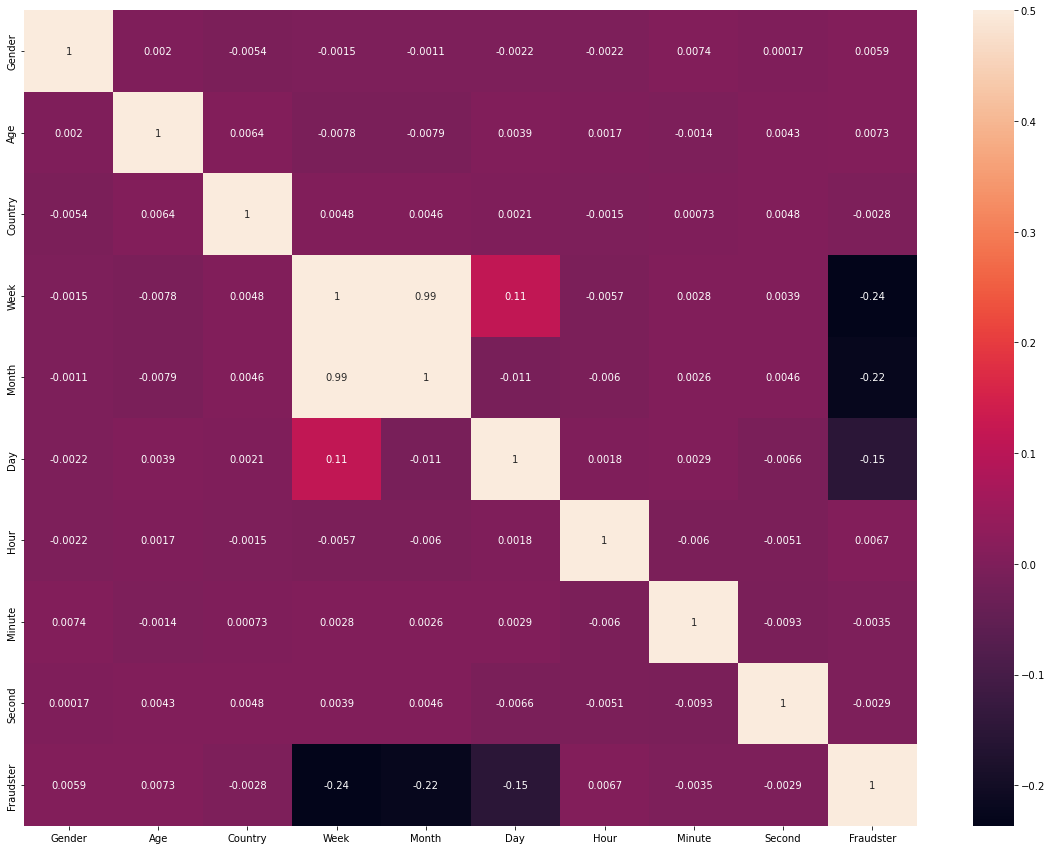

In [62]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_merchant_dataset_train.corr(), annot=True, vmax = 0.5)

##### !!! VIZ TURNED OFF

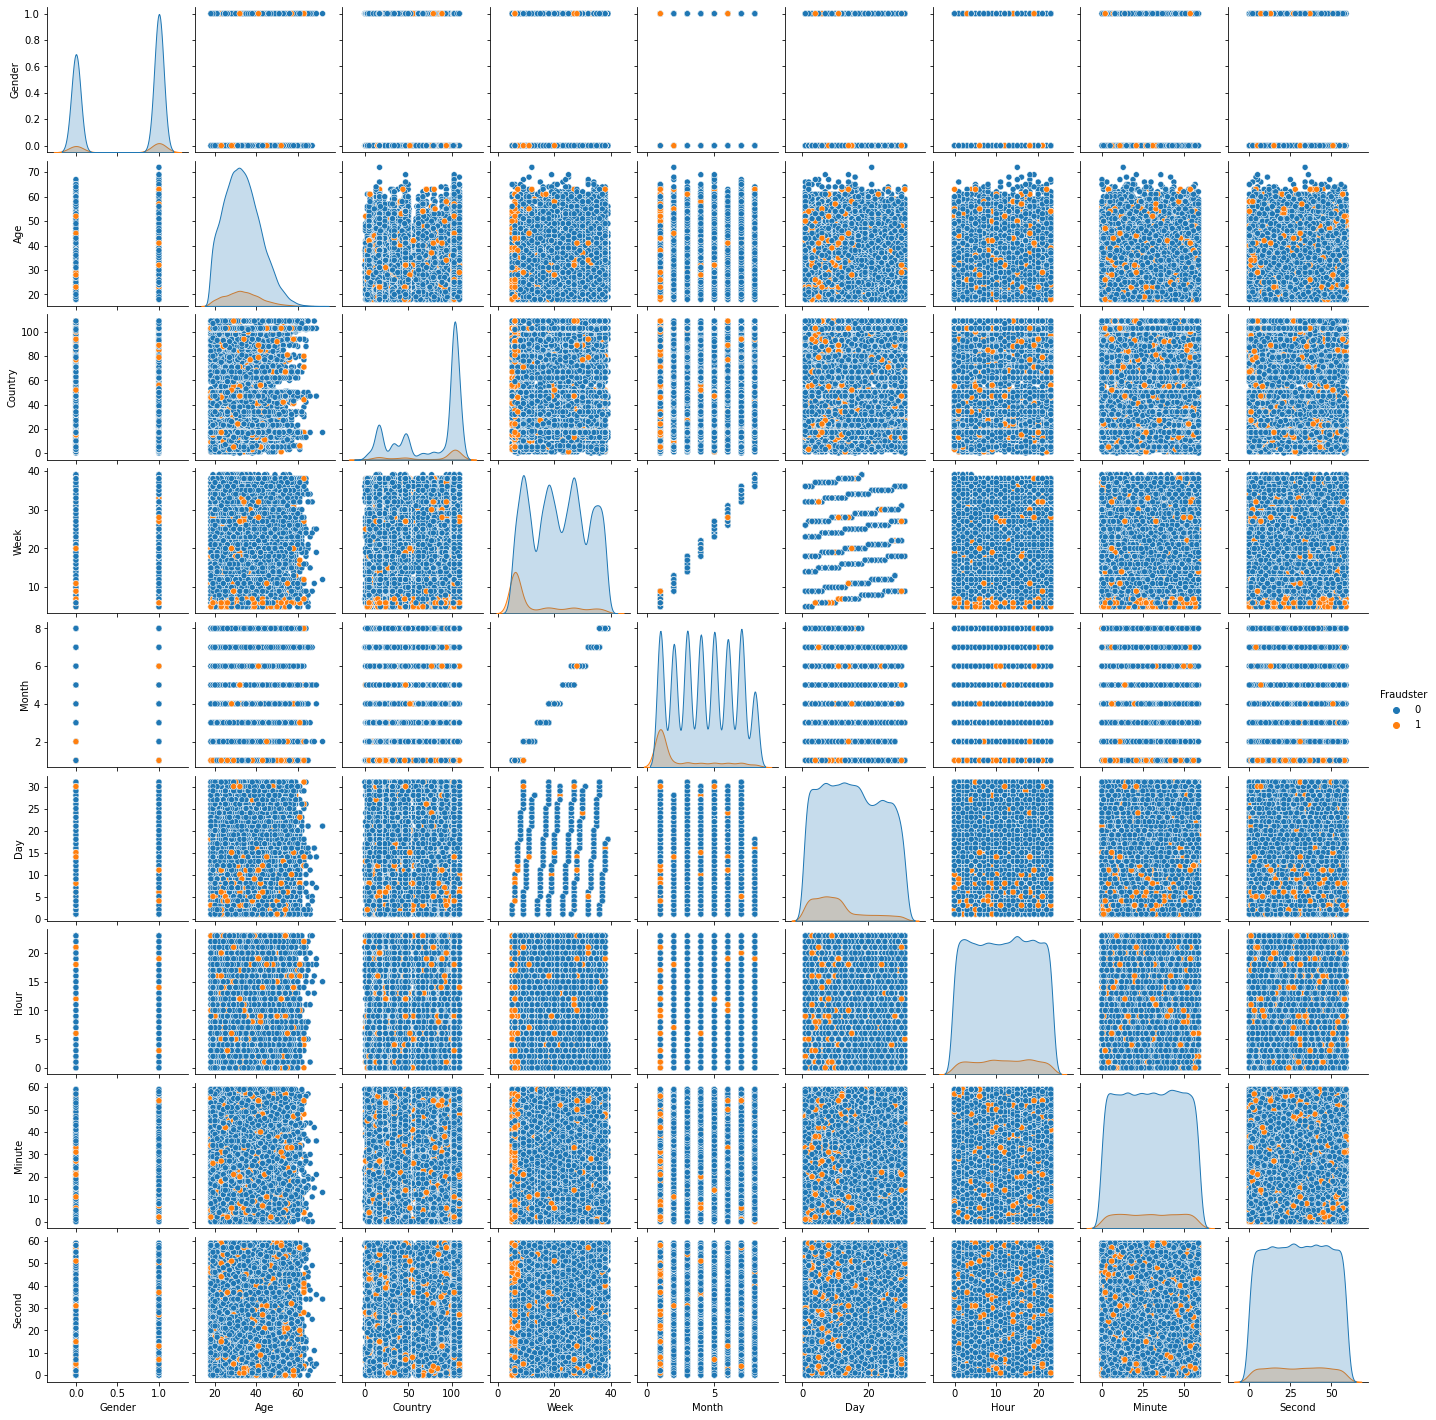

In [63]:
sns.pairplot(corr_merchant_dataset_train, hue='Fraudster').fig.set_size_inches(20,20)

##### Visualisation thoughts

What we can see from the correlations is that fraudsters appear to be mostly registered in the first month(jan)/early weeks from the year and also in the first half of the month.  

In order to reduce bias, it may be good idea to drop Months, since Weeks are their derivatives and they have almost the same meaning.  
Unfortunately, that's the only thing we have here.

Other than that, everything seems all over the place and regression models and Linear SVM's would probably deliver poor results. 

What we know from the registered devices would exclude KNNs as we want exactly the opposite - sometimes to find the fraud between very similar datapoints.

So that basically leaves us to try DecisionTree/Forest or other similar models. Non-Linear SVM's might reveal something, but i'm not so sure about it.

### Orders Dataset

In [64]:
order_all_data_train = pd.merge(left=order_dataset_train, right=target_dataset_train, on='Merchant_ID')

In [65]:
order_all_data_train

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
0           126221  37cea9512f8d  2018-04-29 16:39:26              148   
1           115471  09f12e6efde2  2018-06-16 17:05:40              145   
2           151786  4e69e956e159  2018-10-26 18:00:46               62   
3           140456  663443aaeb82  2018-12-12 05:41:52               28   
4           114721  99258810c121  2018-09-20 11:06:10               70   
...            ...           ...                  ...              ...   
54208       143943  4b0857877884  2018-06-01 14:39:47               90   
54209       125429  2de2749f5442  2018-08-05 21:58:02              120   
54210       159393  11635fac40ff  2018-06-23 01:54:24               92   
54211       133631  6bbcff2f14e5  2018-06-15 21:54:36              148   
54212       113624  e3215298aa07  2018-08-17 06:10:05              105   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
0           Direct          Credit Card       124231          0  
1              SEO          Credit Card       136178          0  
2              Ads     Internet Banking       198611          1  
3              SEO           Debit Card       127993          0  
4              Ads          Credit Card       250146          0  
...            ...                  ...          ...        ...  
54208          Ads          Credit Card        61951          0  
54209          SEO           Debit Card       328145          0  
54210          Ads          Credit Card        28307          0  
54211          Ads     Cash On Delivery       277466          0  
54212          SEO          Credit Card       157675          0  

[54213 rows x 8 columns]

#### Customer ID
Shouldn't necessarily be unique, but lets check:

In [66]:
customer_orders = order_all_data_train['Customer_ID'].value_counts()
customer_orders

124702    7
154763    7
156576    7
111658    7
162123    6
         ..
151064    1
155976    1
127457    1
120799    1
133631    1
Name: Customer_ID, Length: 34081, dtype: int64

In [67]:
get_samples_from_counts(customer_orders, order_all_data_train, 'Customer_ID', 5)

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
9050        150115  a57b6020ac55  2018-04-16 02:18:55               52   
17110       150115  ffa544e406de  2018-05-12 10:50:13               50   
18256       150115  46d458c5bd4f  2018-02-25 01:24:14               60   
31847       150115  0ddc924aa99a  2018-08-07 02:47:26              112   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
9050           SEO          Credit Card       398157          0  
17110       Direct          Credit Card       150110          0  
18256          SEO     Internet Banking       394876          0  
31847          Ads          Credit Card        12169          0

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
10060       150828  ef7a58a981c1  2018-01-09 04:24:23              150   
14539       150828  cf8b05ba7fa1  2018-05-29 02:34:52              105   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
10060          SEO          Credit Card       138274          1  
14539          SEO     Internet Banking        79285          0

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
7080        123603  c50088fe2d58  2018-05-03 08:39:55               65   
11843       123603  2e5f0e0fec8b  2018-07-20 06:52:24               35   
20946       123603  db50b77b12f7  2018-03-24 18:47:52               25   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
7080        Direct          Credit Card       299054          1  
11843          SEO          Credit Card       394875          0  
20946          SEO          Credit Card       180767          0

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
9936        145742  cdea40a6a022  2018-08-03 08:17:15               32   
30119       145742  3882619f9d7c  2018-05-30 05:02:46              252   
39777       145742  f0476c44f4b2  2018-02-11 21:34:47               28   
40222       145742  7d0a98e81e10  2018-06-02 03:32:03               70   
50044       145742  8d8d5b9ffdc1  2018-08-03 18:08:20               82   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
9936           Ads     Internet Banking        55168          0  
30119          Ads          Credit Card       364644          0  
39777       Direct             E-wallet         2215          0  
40222       Direct             E-wallet       138788          0  
50044          Ads     Internet Banking       390456          0

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
5027        122162  2ce79807de8a  2018-10-22 13:04:02              152   
11842       122162  f359ed80bd25  2018-01-09 18:14:14              102   
21153       122162  a5ee1f466ab5  2018-05-03 20:05:07               65   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
5027           SEO          Credit Card       168340          0  
11842          Ads          Credit Card       231105          1  
21153          Ads          Credit Card       162515          0

In [68]:
victims = order_all_data_train['Customer_ID'][order_all_data_train['Fraudster'] == 1].value_counts()
victims

137312    3
143946    3
129340    3
146948    3
113936    3
         ..
142980    1
132526    1
116687    1
161358    1
160661    1
Name: Customer_ID, Length: 4803, dtype: int64

In [69]:
get_samples_from_counts(victims, order_all_data_train, 'Customer_ID', 5)

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
14573       113936  d2292c33a2e5  2018-09-24 14:54:09              148   
15707       113936  b9a12d09b6f5  2018-06-17 07:04:30               88   
15824       113936  5ee241e2ce24  2018-04-10 09:28:28               50   
52293       113936  e14fba286213  2018-07-31 10:19:52               82   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
14573       Direct     Internet Banking       253537          1  
15707          Ads          Credit Card        32095          1  
15824          Ads          Credit Card       304100          0  
52293          SEO     Internet Banking       180568          1

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
19376       158900  522b0750f7ad  2018-11-23 15:58:34               40   
23295       158900  79fd2c2f58dd  2018-09-19 01:49:17               62   
37766       158900  0f30204e567b  2018-01-12 01:42:44              188   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
19376          SEO             E-wallet       362243          1  
23295          SEO          Credit Card        66351          0  
37766          Ads          Credit Card        72833          1

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
5204        146948  f7f67096f8e9  2018-08-17 09:05:02               70   
20892       146948  fdf29e2ffc50  2018-06-18 13:55:26               32   
26512       146948  c12210f09cc5  2018-09-19 16:19:47               48   
42730       146948  43b570a9f8ca  2018-06-29 19:38:59              150   
43450       146948  e0ef361c1eac  2018-03-23 15:21:09              200   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
5204           Ads          Credit Card       187993          0  
20892          SEO           Debit Card       370996          1  
26512       Direct          Credit Card       168765          1  
42730          SEO          Credit Card       393654          0  
43450          SEO             E-wallet        72311          1

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
3379        151644  05a349d24ebd  2018-01-09 17:24:06               55   
4069        151644  15c9cd73cd7b  2018-01-14 09:17:49              145   
7366        151644  8aefd396c024  2018-03-30 03:27:40               68   
8880        151644  8960491ff602  2018-08-27 11:41:40               65   
48214       151644  cda84d6287fc  2018-07-31 00:17:04              122   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
3379           Ads           Debit Card       235771          1  
4069           SEO     Cash On Delivery       298170          1  
7366        Direct           Debit Card       366733          0  
8880           Ads          Credit Card       111713          0  
48214       Direct          Credit Card       381929          0

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
6074        141785  05adf4c652da  2018-01-08 21:48:13              112   
38197       141785  d50824b0c869  2018-01-13 01:39:07              162   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
6074           Ads     Internet Banking       121970          1  
38197          SEO          Credit Card       292565          1

Okay, so basically we have 1 order from each merchant, some of the customers may have a few orders and some of them have purchased from a fraudster.

What's more is that there is a pattern where some customers are more prone to a fraud and usually frauded more than once, but there are some 'occasional' ones as well.

#### Order ID #TODO hex to dec?
The data seems to be a unique hexadecimal number. We can convert it to decimals I guess... But do we need it at all? There is unique value for each record and it doesnt give us any insight... We could drop it anyway

In [70]:
order_all_data_train['Order_ID'].describe()

count            54213
unique           54213
top       37cea9512f8d
freq                 1
Name: Order_ID, dtype: object

In [71]:
order_all_data_train['Order_ID'] = order_all_data_train['Order_ID'].apply(lambda x: hex(int(x, 16)))

In [72]:
order_all_data_train

Customer_ID        Order_ID        Date_of_Order  Order_Value_USD  \
0           126221  0x37cea9512f8d  2018-04-29 16:39:26              148   
1           115471   0x9f12e6efde2  2018-06-16 17:05:40              145   
2           151786  0x4e69e956e159  2018-10-26 18:00:46               62   
3           140456  0x663443aaeb82  2018-12-12 05:41:52               28   
4           114721  0x99258810c121  2018-09-20 11:06:10               70   
...            ...             ...                  ...              ...   
54208       143943  0x4b0857877884  2018-06-01 14:39:47               90   
54209       125429  0x2de2749f5442  2018-08-05 21:58:02              120   
54210       159393  0x11635fac40ff  2018-06-23 01:54:24               92   
54211       133631  0x6bbcff2f14e5  2018-06-15 21:54:36              148   
54212       113624  0xe3215298aa07  2018-08-17 06:10:05              105   

      Order_Source Order_Payment_Method  Merchant_ID  Fraudster  
0           Direct          Credit Card       124231          0  
1              SEO          Credit Card       136178          0  
2              Ads     Internet Banking       198611          1  
3              SEO           Debit Card       127993          0  
4              Ads          Credit Card       250146          0  
...            ...                  ...          ...        ...  
54208          Ads          Credit Card        61951          0  
54209          SEO           Debit Card       328145          0  
54210          Ads          Credit Card        28307          0  
54211          Ads     Cash On Delivery       277466          0  
54212          SEO          Credit Card       157675          0  

[54213 rows x 8 columns]

In [73]:
order_all_data_train.drop(columns=['Order_ID'], inplace=True)

#### Order date

No obvious patterns here. We can convert datetime to separate columns here as well.

##### Processing feature table

In [74]:
regex_datetime_split_pattern = '-| |:'
date_of_order_splitted = pd.DataFrame(columns=['Year', 'Week', 'Month', 'Day', 'Hour', 'Minute', 'Second'])
date_of_order_splitted[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = \
    order_all_data_train['Date_of_Order'].str.split(regex_datetime_split_pattern, n=6, expand=True)
date_of_order_splitted = date_of_order_splitted.applymap(int, na_action='ignore')
date_of_order_splitted['Week'] = date_of_order_splitted.apply(lambda x: convert_to_week(x.Month, x.Day), axis=1)

In [75]:
date_of_order_splitted

Year  Week  Month  Day  Hour  Minute  Second
0      2018    22      4   29    16      39      26
1      2018    29      6   16    17       5      40
2      2018    49     10   26    18       0      46
3      2018    55     12   12     5      41      52
4      2018    42      9   20    11       6      10
...     ...   ...    ...  ...   ...     ...     ...
54208  2018    26      6    1    14      39      47
54209  2018    37      8    5    21      58       2
54210  2018    30      6   23     1      54      24
54211  2018    28      6   15    21      54      36
54212  2018    38      8   17     6      10       5

[54213 rows x 7 columns]

In [76]:
date_of_order_splitted['Week'].value_counts()

40    2834
27    2689
39    1898
18    1802
26    1787
24    1630
35    1619
34    1616
29    1591
6     1590
36    1589
37    1563
25    1548
28    1540
33    1539
30    1536
38    1533
21    1481
20    1421
32    1376
19    1284
41    1218
42    1191
48    1148
49    1108
23    1101
43    1067
17    1061
7     1048
16     954
46     944
22     903
15     843
47     843
9      646
12     643
11     605
10     522
45     521
14     426
50     425
51     340
8      236
31     232
5      215
52     142
54     122
13     116
55     107
56      20
Name: Week, dtype: int64

In [77]:
date_of_order_splitted['Year'].value_counts()

2018    54213
Name: Year, dtype: int64

Since all are the same year, we can drop it.

In [78]:
date_of_order_splitted = date_of_order_splitted.drop(columns='Year')

In [79]:
date_of_order_splitted

Week  Month  Day  Hour  Minute  Second
0        22      4   29    16      39      26
1        29      6   16    17       5      40
2        49     10   26    18       0      46
3        55     12   12     5      41      52
4        42      9   20    11       6      10
...     ...    ...  ...   ...     ...     ...
54208    26      6    1    14      39      47
54209    37      8    5    21      58       2
54210    30      6   23     1      54      24
54211    28      6   15    21      54      36
54212    38      8   17     6      10       5

[54213 rows x 6 columns]

In [80]:
order_all_data_train = order_all_data_train.drop(columns=['Date_of_Order'])

In [81]:
order_all_data_train = order_all_data_train.join(date_of_order_splitted)

#### Order value

Value of orders with no frauds

In [82]:
order_all_data_train['Order_Value_USD'][order_all_data_train['Fraudster'] == 0].describe()

count    49188.000000
mean        92.213934
std         45.635488
min         22.000000
25%         55.000000
50%         88.000000
75%        122.000000
max        385.000000
Name: Order_Value_USD, dtype: float64

---

Value of orders with frauds

In [83]:
order_all_data_train['Order_Value_USD'][order_all_data_train['Fraudster'] == 1].describe()

count    5025.000000
mean       92.389851
std        46.045665
min        22.000000
25%        55.000000
50%        88.000000
75%       122.000000
max       270.000000
Name: Order_Value_USD, dtype: float64

Can't see any patterns here as well... There is almost no difference between value of orders with frauds and without.

#### Order Source

In [84]:
order_all_data_train['Order_Source'][order_all_data_train['Fraudster'] == 0].value_counts()

SEO       19991
Ads       19298
Direct     9899
Name: Order_Source, dtype: int64

In [85]:
order_all_data_train['Order_Source'][order_all_data_train['Fraudster'] == 1].value_counts()

Ads       1961
SEO       1893
Direct    1171
Name: Order_Source, dtype: int64

Looks like direct orders are more prone to frauds.

#### Order payment method

In [86]:
order_all_data_train['Order_Payment_Method'][order_all_data_train['Fraudster'] == 0].value_counts()

Credit Card         19682
Internet Banking    12059
Debit Card           8254
E-wallet             7938
Cash On Delivery     1255
Name: Order_Payment_Method, dtype: int64

In [87]:
order_all_data_train['Order_Payment_Method'][order_all_data_train['Fraudster'] == 1].value_counts()

Credit Card         2162
Internet Banking    1134
Debit Card           816
E-wallet             801
Cash On Delivery     112
Name: Order_Payment_Method, dtype: int64

Can't see any patterns here as well... There is almost no difference between payment methods with frauds and without.

#### Visualization

In [88]:
corr_order_dataset_train = order_dataset_train.join(date_of_order_splitted)
corr_order_dataset_train = pd.merge(left=corr_order_dataset_train, right=target_dataset_train, on='Merchant_ID')

LE = LabelEncoder()
corr_order_dataset_train['Order_Source'] = LE.fit_transform(corr_order_dataset_train['Order_Source'])
corr_order_dataset_train['Order_Payment_Method'] = LE.fit_transform(corr_order_dataset_train['Order_Payment_Method'])

corr_order_dataset_train = corr_order_dataset_train.drop(columns=[
    'Order_ID',
    'Date_of_Order',
    'Customer_ID',
    'Merchant_ID'])

In [89]:
corr_order_dataset_train

Order_Value_USD  Order_Source  Order_Payment_Method  Week  Month  Day  \
0                  148             1                     1    22      4   29   
1                  145             2                     1    29      6   16   
2                   62             0                     4    49     10   26   
3                   28             2                     2    55     12   12   
4                   70             0                     1    42      9   20   
...                ...           ...                   ...   ...    ...  ...   
54208               90             0                     1    26      6    1   
54209              120             2                     2    37      8    5   
54210               92             0                     1    30      6   23   
54211              148             0                     0    28      6   15   
54212              105             2                     1    38      8   17   

       Hour  Minute  Second  Fraudster  
0        16      39      26          0  
1        17       5      40          0  
2        18       0      46          1  
3         5      41      52          0  
4        11       6      10          0  
...     ...     ...     ...        ...  
54208    14      39      47          0  
54209    21      58       2          0  
54210     1      54      24          0  
54211    21      54      36          0  
54212     6      10       5          0  

[54213 rows x 10 columns]

<AxesSubplot:>

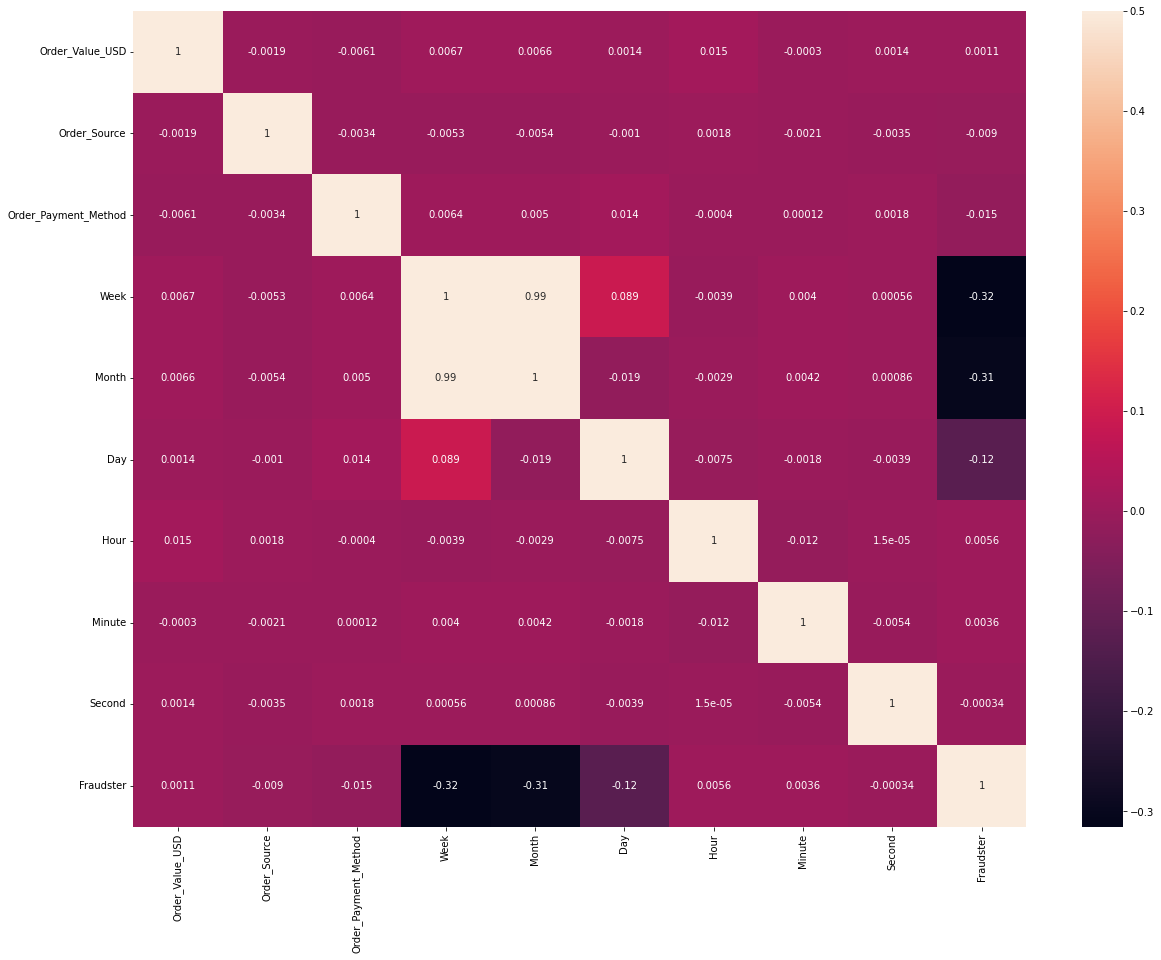

In [90]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_order_dataset_train.corr(), annot=True, vmax = 0.5)

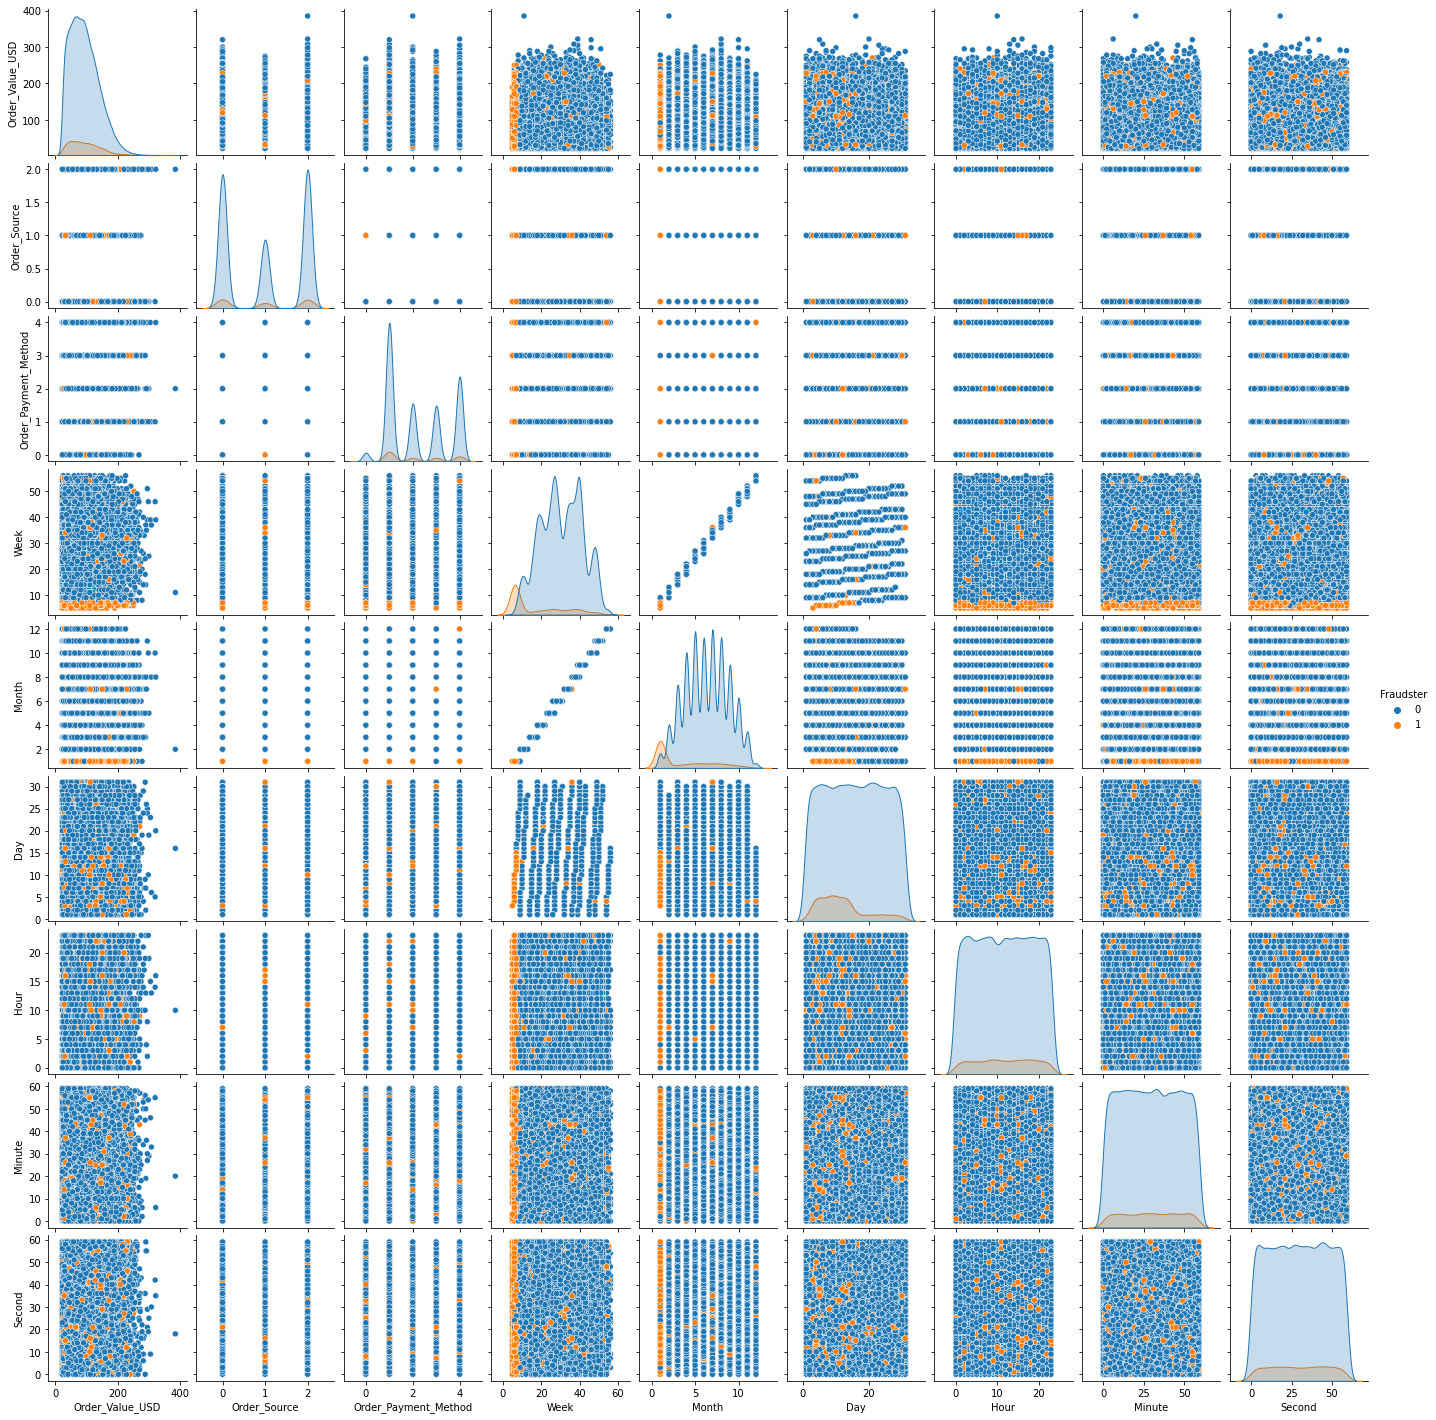

In [91]:
sns.pairplot(corr_order_dataset_train, hue='Fraudster').fig.set_size_inches(20,20)

All over the place again. Same patterns with the month and day (Mostly January, and the first half of the months). Perhaps we can use number of week in the year instead of month/day.

The observation that some of the victims are actually more prone, lets call them 'serial victims', kind of appears again (Customer_ID > 140,000) which are maybe new(unexperienced) or younger customers.

#### Merchant ID

In [92]:
order_dataset_train['Merchant_ID'].value_counts()

124231    1
11699     1
373439    1
148049    1
96865     1
         ..
83413     1
329499    1
159879    1
165373    1
157675    1
Name: Merchant_ID, Length: 54213, dtype: int64

In [93]:
order_dataset_merged = pd.concat([order_dataset_train, order_dataset_test])
order_dataset_merged['Merchant_ID'].value_counts()

124231    1
304866    1
356541    1
136474    1
3312      1
         ..
22733     1
251047    1
368945    1
12487     1
319050    1
Name: Merchant_ID, Length: 67767, dtype: int64

Hmm... only 1 order per merchant? Seems phishy... and unfortunate for our future model...

## ML algorithm dataset preprocessing

### Train Datasets

Remove columns we wont need anymore and replace them with the preprocessed features. We can also One-Hot-Encode 'Country' and 'Gender' (perhaps gender converting to 0-1 is enough).

In [94]:
LE = LabelEncoder()
merchant_dataset_train = pd.get_dummies(merchant_dataset_train, columns=['Country'])
merchant_dataset_train['Gender'] = LE.fit_transform(merchant_dataset_train['Gender'])

In [95]:
merchant_dataset_train = merchant_dataset_train.join([date_and_time_splitted, device_id_splitted])

In [96]:
merchant_dataset_train = merchant_dataset_train.drop(columns=[
    'Month',
    'Ecommerce_Provider_ID', 
    'Merchant_Registration_Date', 
    'Registered_Device_ID', 
    'IP_Address'])

In [97]:
order_dataset_train = order_all_data_train.drop(columns=['Fraudster'])

In [98]:
order_dataset_train = pd.get_dummies(order_dataset_train, columns=['Order_Source', 'Order_Payment_Method'])

Ok, so, after all, we have the following training datasets, which should be ready for our model:

In [99]:
merchant_dataset_train

Merchant_ID  Gender  Age  Country_Afghanistan  Country_Algeria  \
0            50448       0   39                    0                0   
1           338754       1   35                    0                0   
2           291127       0   40                    0                0   
3           319919       1   37                    0                0   
4           195911       0   27                    0                0   
...            ...     ...  ...                  ...              ...   
54208       222372       1   43                    0                0   
54209        73491       1   41                    0                0   
54210       176456       0   36                    0                0   
54211       228277       1   18                    0                0   
54212       259077       0   31                    0                0   

       Country_Angola  Country_Argentina  Country_Armenia  Country_Australia  \
0                   0                  0                0                  0   
1                   0                  0                0                  0   
2                   0                  0                0                  0   
3                   0                  0                0                  0   
4                   0                  0                0                  0   
...               ...                ...              ...                ...   
54208               0                  0                0                  0   
54209               0                  0                0                  0   
54210               0                  0                0                  0   
54211               0                  0                0                  0   
54212               0                  0                0                  0   

       Country_Austria  ...  dev_id_3  dev_id_4  dev_id_5  dev_id_6  dev_id_7  \
0                    0  ...        81        77        77        90        84   
1                    0  ...        73        76        76        66        82   
2                    0  ...        72        83        85        71        75   
3                    1  ...        88        77        80        76        81   
4                    0  ...        75        87        77        83        87   
...                ...  ...       ...       ...       ...       ...       ...   
54208                0  ...        77        69        78        71        67   
54209                0  ...        80        79        89        68        79   
54210                0  ...        78        65        74        77        71   
54211                0  ...        79        77        78        90        70   
54212                0  ...        70        67        89        80        89   

       dev_id_8  dev_id_9  dev_id_10  dev_id_11  dev_id_12  
0            86        79         90         85         84  
1            81        90         78         75         83  
2            68        65         89         90         86  
3            89        88         82         77         89  
4            72        67         77         73         68  
...         ...       ...        ...        ...        ...  
54208        73        65         86         79         75  
54209        78        84         89         67         78  
54210        78        82         81         80         90  
54211        65        72         90         76         83  
54212        81        76         76         77         79  

[54213 rows x 130 columns]

In [100]:
order_dataset_train

Customer_ID  Order_Value_USD  Merchant_ID  Week  Month  Day  Hour  \
0           126221              148       124231    22      4   29    16   
1           115471              145       136178    29      6   16    17   
2           151786               62       198611    49     10   26    18   
3           140456               28       127993    55     12   12     5   
4           114721               70       250146    42      9   20    11   
...            ...              ...          ...   ...    ...  ...   ...   
54208       143943               90        61951    26      6    1    14   
54209       125429              120       328145    37      8    5    21   
54210       159393               92        28307    30      6   23     1   
54211       133631              148       277466    28      6   15    21   
54212       113624              105       157675    38      8   17     6   

       Minute  Second  Order_Source_Ads  Order_Source_Direct  \
0          39      26                 0                    1   
1           5      40                 0                    0   
2           0      46                 1                    0   
3          41      52                 0                    0   
4           6      10                 1                    0   
...       ...     ...               ...                  ...   
54208      39      47                 1                    0   
54209      58       2                 0                    0   
54210      54      24                 1                    0   
54211      54      36                 1                    0   
54212      10       5                 0                    0   

       Order_Source_SEO  Order_Payment_Method_Cash On Delivery  \
0                     0                                      0   
1                     1                                      0   
2                     0                                      0   
3                     1                                      0   
4                     0                                      0   
...                 ...                                    ...   
54208                 0                                      0   
54209                 1                                      0   
54210                 0                                      0   
54211                 0                                      1   
54212                 1                                      0   

       Order_Payment_Method_Credit Card  Order_Payment_Method_Debit Card  \
0                                     1                                0   
1                                     1                                0   
2                                     0                                0   
3                                     0                                1   
4                                     1                                0   
...                                 ...                              ...   
54208                                 1                                0   
54209                                 0                                1   
54210                                 1                                0   
54211                                 0                                0   
54212                                 1                                0   

       Order_Payment_Method_E-wallet  Order_Payment_Method_Internet Banking  
0                                  0                                      0  
1                                  0                                      0  
2                                  0                                      1  
3                                  0                                      0  
4                                  0                                      0  
...                              ...                                    ...  
54208                              0                                     

### Prediction Datasets

#### Merchants

Would be nice if we do the same preprocessing for the prediction datasets.

Basically the same what was done to the train datasets.

We can use these steps to create our data preprocessing pipeline.

In [101]:
merchant_dataset_predict = pd.read_csv('data/predict-if-the-merchant-is-fraudster/test_merchant_data-1561627903902.csv')
merchant_dataset_predict

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                    1746213        53637        2018-02-11 20:50:29   
1                    1746213       243517        2018-04-06 13:19:39   
2                    1746213       343640        2018-01-12 16:47:49   
3                    1746213        69889        2018-02-19 21:58:52   
4                    1746213       125706        2018-05-17 15:50:19   
...                      ...          ...                        ...   
13549                1746213       279884        2018-04-21 03:10:18   
13550                1746213       206253        2018-06-10 11:16:31   
13551                1746213       313049        2018-02-27 00:55:48   
13552                1746213       304081        2018-05-20 12:17:43   
13553                1746213       319050        2018-03-01 16:02:01   

      Registered_Device_ID Gender  Age      IP_Address  
0            PTMLBENYMQCTV      F   40  134.162.124.62  
1            HMCLDZUZPWZRR      M   39    152.76.98.87  
2            VLGSMAPXISSEJ      M   23    31.202.3.255  
3            ZINHISBBOKQXT      M   34  12.242.168.185  
4            WFKEAOTPHTYEO      M   20    26.61.210.47  
...                    ...    ...  ...             ...  
13549        JNYAWEFRSBGCK      M   20  164.83.157.213  
13550        HYEKCYQYSPVIO      F   30    40.46.42.142  
13551        OVSRMAXBANHKT      F   44   210.44.212.84  
13552        STSCTKTROPBTH      F   39    46.244.39.59  
13553        LGTEXIKCLMICZ      M   41  205.156.234.14  

[13554 rows x 7 columns]

Extract countries from IP addresses:

In [102]:
country_extractor(merchant_dataset_predict, ip_adress_country, 'merchant_dataset_predict_country')

Split device ID's and date-time into separate columns:

In [103]:
merchant_dataset_predict_split_device = split_devices_id_feature(merchant_dataset_predict)
merchant_dataset_predict_split_date = split_date_time(merchant_dataset_predict, 'Merchant_Registration_Date')
merchant_dataset_predict = merchant_dataset_predict.join([merchant_dataset_predict_split_date, merchant_dataset_predict_split_device])

Drop not needed columns:

In [104]:
merchant_dataset_predict = merchant_dataset_predict.drop(columns=[
    'Ecommerce_Provider_ID', 
    'Merchant_Registration_Date', 
    'Registered_Device_ID', 
    'IP_Address'])

Encoding Country and Gender columns:

In [105]:
LE = LabelEncoder()
merchant_dataset_predict = pd.get_dummies(merchant_dataset_predict, columns=['Country'])
merchant_dataset_predict['Gender'] = LE.fit_transform(merchant_dataset_predict['Gender'])

Unfortunately, country one-hot-encoding is making a column mismatch... That's not good :( We have to make columns equivalent

We can make a superset of the two dataset columns and reindex both of them with a fill value of '0'

In [106]:
merchant_columns = merchant_dataset_train.columns.union(merchant_dataset_predict.columns)

In [107]:
merchant_dataset_train = merchant_dataset_train.reindex(columns=merchant_columns, fill_value=0)
merchant_dataset_predict = merchant_dataset_predict.reindex(columns=merchant_columns, fill_value=0)

Dataset shape after all manipulations:

In [108]:
merchant_dataset_predict

Age  Country_Afghanistan  Country_Algeria  Country_Angola  \
0       40                    0                0               0   
1       39                    0                0               0   
2       23                    0                0               0   
3       34                    0                0               0   
4       20                    0                0               0   
...    ...                  ...              ...             ...   
13549   20                    0                0               0   
13550   30                    0                0               0   
13551   44                    0                0               0   
13552   39                    0                0               0   
13553   41                    0                0               0   

       Country_Argentina  Country_Armenia  Country_Australia  Country_Austria  \
0                      0                0                  0                0   
1                      0                0                  1                0   
2                      0                0                  0                0   
3                      0                0                  0                0   
4                      0                0                  0                0   
...                  ...              ...                ...              ...   
13549                  0                0                  0                0   
13550                  0                0                  0                0   
13551                  0                0                  0                0   
13552                  0                0                  0                0   
13553                  0                0                  0                0   

       Country_Azerbaijan  Country_Bangladesh  ...  dev_id_11  dev_id_12  \
0                       0                   0  ...         84         86   
1                       0                   0  ...         82         82   
2                       0                   0  ...         69         74   
3                       0                   0  ...         88         84   
4                       0                   0  ...         69         79   
...                   ...                 ...  ...        ...        ...   
13549                   0                   0  ...         67         75   
13550                   0                   0  ...         73         79   
13551                   0                   0  ...         75         84   
13552                   0                   0  ...         84         72   
13553                   0                   0  ...         67         90   

       dev_id_2  dev_id_3  dev_id_4  dev_id_5  dev_id_6  dev_id_7  dev_id_8  \
0            77        76        66        69        78        89        77   
1            67        76        68        90        85        90        80   
2            71        83        77        65        80        88        73   
3            78        72        73        83        66        66        79   
4            75        69        65        79        84        80        72   
...         ...       ...       ...       ...       ...       ...       ...   
13549        89        65        87        69        70        82        83   
13550        69        75        67        89        81        89        83   
13551        83        82        77        65        88        66        65   
13552        83        67        84        75        84        82        79   
13553        84        69        88        73        75        67        76   

       dev_id_9  
0            81  
1            87  
2            83  
3            75  
4            84  
...         ...  
13549        66  
13550        80  
13551        78  
13552        80  
13553        77  

[13554 rows x 131 columns]

#### Orders

In [109]:
order_dataset_predict = pd.read_csv('data/predict-if-the-merchant-is-fraudster/test_order_data-1561627931868.csv')
order_dataset_predict

Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
0           157068  a032de091f51  2018-03-09 09:09:42               60   
1           112534  0d563f0606d6  2018-06-13 20:11:19               28   
2           148774  18fb0fa888b6  2018-04-14 04:19:36               75   
3           114528  ed1eb920d721  2018-04-01 13:55:44               98   
4           120940  313dcf962627  2018-05-25 02:08:18               35   
...            ...           ...                  ...              ...   
13549       153457  f0caea3c0bbb  2018-06-25 23:00:41               92   
13550       139271  a23964a17f12  2018-07-14 19:20:44              128   
13551       156228  28e0b6aa4aca  2018-03-05 12:08:52               98   
13552       160078  3e1d365937d6  2018-05-22 18:30:43               68   
13553       112698  f50ccf3e962f  2018-06-06 09:19:01              100   

      Order_Source Order_Payment_Method  Merchant_ID  
0              SEO          Credit Card        53637  
1              SEO          Credit Card       243517  
2              Ads           Debit Card       343640  
3              SEO          Credit Card        69889  
4              SEO          Credit Card       125706  
...            ...                  ...          ...  
13549          SEO          Credit Card       279884  
13550          SEO     Internet Banking       206253  
13551       Direct             E-wallet       313049  
13552          SEO           Debit Card       304081  
13553          Ads           Debit Card       319050  

[13554 rows x 7 columns]

Split date-time into separate columns:

In [110]:
order_dataset_predict_split_date = split_date_time(order_dataset_predict, 'Date_of_Order')
order_dataset_predict = order_dataset_predict.join(order_dataset_predict_split_date)

In [111]:
order_dataset_predict = pd.get_dummies(order_dataset_predict, columns=['Order_Source', 'Order_Payment_Method'])

In [112]:
order_dataset_predict.drop(columns=['Order_ID', 'Date_of_Order'], inplace=True)

Now reindex order dataset columns, just in case:

In [113]:
order_columns = order_dataset_train.columns.union(order_dataset_predict.columns)
order_dataset_train = order_dataset_train.reindex(columns=order_columns, fill_value=0)
order_dataset_predict = order_dataset_predict.reindex(columns=order_columns, fill_value=0)

Dataset shape after all manipulations:

In [114]:
order_dataset_predict

Customer_ID  Order_Value_USD  Merchant_ID  Week  Month  Day  Hour  \
0           157068               60        53637    15      3    9     9   
1           112534               28       243517    28      6   13    20   
2           148774               75       343640    20      4   14     4   
3           114528               98        69889    18      4    1    13   
4           120940               35       125706    26      5   25     2   
...            ...              ...          ...   ...    ...  ...   ...   
13549       153457               92       279884    30      6   25    23   
13550       139271              128       206253    34      7   14    19   
13551       156228               98       313049    15      3    5    12   
13552       160078               68       304081    26      5   22    18   
13553       112698              100       319050    27      6    6     9   

       Minute  Second  Order_Source_Ads  Order_Source_Direct  \
0           9      42                 0                    0   
1          11      19                 0                    0   
2          19      36                 1                    0   
3          55      44                 0                    0   
4           8      18                 0                    0   
...       ...     ...               ...                  ...   
13549       0      41                 0                    0   
13550      20      44                 0                    0   
13551       8      52                 0                    1   
13552      30      43                 0                    0   
13553      19       1                 1                    0   

       Order_Source_SEO  Order_Payment_Method_Cash On Delivery  \
0                     1                                      0   
1                     1                                      0   
2                     0                                      0   
3                     1                                      0   
4                     1                                      0   
...                 ...                                    ...   
13549                 1                                      0   
13550                 1                                      0   
13551                 0                                      0   
13552                 1                                      0   
13553                 0                                      0   

       Order_Payment_Method_Credit Card  Order_Payment_Method_Debit Card  \
0                                     1                                0   
1                                     1                                0   
2                                     0                                1   
3                                     1                                0   
4                                     1                                0   
...                                 ...                              ...   
13549                                 1                                0   
13550                                 0                                0   
13551                                 0                                0   
13552                                 0                                1   
13553                                 0                                1   

       Order_Payment_Method_E-wallet  Order_Payment_Method_Internet Banking  
0                                  0                                      0  
1                                  0                                      0  
2                                  0                                      0  
3                                  0                                      0  
4                                  0                                      0  
...                              ...                                    ...  
13549                              0                                     

### Merge and compare

In [115]:
all_data_train = pd.merge(merchant_dataset_train, order_dataset_train, on='Merchant_ID')
all_data_train

Age  Country_Afghanistan  Country_Algeria  Country_Angola  \
0       39                    0                0               0   
1       35                    0                0               0   
2       40                    0                0               0   
3       37                    0                0               0   
4       27                    0                0               0   
...    ...                  ...              ...             ...   
54208   43                    0                0               0   
54209   41                    0                0               0   
54210   36                    0                0               0   
54211   18                    0                0               0   
54212   31                    0                0               0   

       Country_Argentina  Country_Armenia  Country_Australia  Country_Austria  \
0                      0                0                  0                0   
1                      0                0                  0                0   
2                      0                0                  0                0   
3                      0                0                  0                1   
4                      0                0                  0                0   
...                  ...              ...                ...              ...   
54208                  0                0                  0                0   
54209                  0                0                  0                0   
54210                  0                0                  0                0   
54211                  0                0                  0                0   
54212                  0                0                  0                0   

       Country_Azerbaijan  Country_Bangladesh  ...  Minute_y  Second_y  \
0                       0                   0  ...        59        13   
1                       0                   0  ...        19        47   
2                       0                   0  ...         6        26   
3                       0                   0  ...        46        51   
4                       0                   0  ...         2        44   
...                   ...                 ...  ...       ...       ...   
54208                   0                   0  ...        18        37   
54209                   0                   0  ...        49        53   
54210                   0                   0  ...        20         7   
54211                   0                   0  ...        35        43   
54212                   0                   0  ...        30        11   

       Order_Source_Ads  Order_Source_Direct  Order_Source_SEO  \
0                     0                    0                 1   
1                     0                    0                 1   
2                     0                    0                 1   
3                     0                    1                 0   
4                     0                    0                 1   
...                 ...                  ...               ...   
54208                 1                    0                 0   
54209                 1                    0                 0   
54210                 0                    1                 0   
54211                 1                    0                 0   
54212                 0                    0                 1   

       Order_Payment_Method_Cash On Delivery  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
54208                                      0   
54209                                      0   
54210                                      0   
54211                                      0   
54212  

In [116]:
all_data_predict = pd.merge(merchant_dataset_predict, order_dataset_predict, on='Merchant_ID')
all_data_predict

Age  Country_Afghanistan  Country_Algeria  Country_Angola  \
0       40                    0                0               0   
1       39                    0                0               0   
2       23                    0                0               0   
3       34                    0                0               0   
4       20                    0                0               0   
...    ...                  ...              ...             ...   
13549   20                    0                0               0   
13550   30                    0                0               0   
13551   44                    0                0               0   
13552   39                    0                0               0   
13553   41                    0                0               0   

       Country_Argentina  Country_Armenia  Country_Australia  Country_Austria  \
0                      0                0                  0                0   
1                      0                0                  1                0   
2                      0                0                  0                0   
3                      0                0                  0                0   
4                      0                0                  0                0   
...                  ...              ...                ...              ...   
13549                  0                0                  0                0   
13550                  0                0                  0                0   
13551                  0                0                  0                0   
13552                  0                0                  0                0   
13553                  0                0                  0                0   

       Country_Azerbaijan  Country_Bangladesh  ...  Minute_y  Second_y  \
0                       0                   0  ...         9        42   
1                       0                   0  ...        11        19   
2                       0                   0  ...        19        36   
3                       0                   0  ...        55        44   
4                       0                   0  ...         8        18   
...                   ...                 ...  ...       ...       ...   
13549                   0                   0  ...         0        41   
13550                   0                   0  ...        20        44   
13551                   0                   0  ...         8        52   
13552                   0                   0  ...        30        43   
13553                   0                   0  ...        19         1   

       Order_Source_Ads  Order_Source_Direct  Order_Source_SEO  \
0                     0                    0                 1   
1                     0                    0                 1   
2                     1                    0                 0   
3                     0                    0                 1   
4                     0                    0                 1   
...                 ...                  ...               ...   
13549                 0                    0                 1   
13550                 0                    0                 1   
13551                 0                    1                 0   
13552                 0                    0                 1   
13553                 1                    0                 0   

       Order_Payment_Method_Cash On Delivery  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
13549                                      0   
13550                                      0   
13551                                      0   
13552                                      0   
13553  

Now we must make sure that our observations train and target data matches on Merchant_ID:

In [117]:
fraudsters_train = pd.read_csv('data/predict-if-the-merchant-is-fraudster/train-1561627878332.csv')
fraudsters_predict = pd.read_csv('data/predict-if-the-merchant-is-fraudster/samplesubmission-1561627564513.csv')

In [118]:
fraudsters_predict['Fraudster'].value_counts()

0    13554
Name: Fraudster, dtype: int64

In this case fraudsters are 0, because they aren't predicted yet, but the main idea here is the methodology.

In [119]:
train_data_plus_targets = all_data_train.merge(fraudsters_train, on='Merchant_ID')
all_data_train, fraudsters_train = \
    train_data_plus_targets.drop(columns=['Fraudster']), train_data_plus_targets[['Merchant_ID','Fraudster']]

In [120]:
predict_data_plus_targets = all_data_predict.merge(fraudsters_predict, on='Merchant_ID')
all_data_predict, fraudsters_predict = \
    predict_data_plus_targets.drop(columns=['Fraudster']), predict_data_plus_targets[['Merchant_ID']]

Now check if everything is set up correctly:

In [121]:
(all_data_train.columns).equals(all_data_predict.columns)

True

In [122]:
fraudsters_train['Merchant_ID'].equals(all_data_train['Merchant_ID'])

True

In [123]:
fraudsters_predict['Merchant_ID'].equals(all_data_predict['Merchant_ID'])

True

In [124]:
fraudsters_train.drop(columns='Merchant_ID', inplace=True)
all_data_train.drop(columns='Merchant_ID', inplace=True)
all_data_predict.drop(columns='Merchant_ID', inplace=True)

C:\Users\ebasii\AppData\Local\Temp\ipykernel_8988\1775134259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudsters_train.drop(columns='Merchant_ID', inplace=True)


In [125]:
all_data_train

Age  Country_Afghanistan  Country_Algeria  Country_Angola  \
0       39                    0                0               0   
1       35                    0                0               0   
2       40                    0                0               0   
3       37                    0                0               0   
4       27                    0                0               0   
...    ...                  ...              ...             ...   
54208   43                    0                0               0   
54209   41                    0                0               0   
54210   36                    0                0               0   
54211   18                    0                0               0   
54212   31                    0                0               0   

       Country_Argentina  Country_Armenia  Country_Australia  Country_Austria  \
0                      0                0                  0                0   
1                      0                0                  0                0   
2                      0                0                  0                0   
3                      0                0                  0                1   
4                      0                0                  0                0   
...                  ...              ...                ...              ...   
54208                  0                0                  0                0   
54209                  0                0                  0                0   
54210                  0                0                  0                0   
54211                  0                0                  0                0   
54212                  0                0                  0                0   

       Country_Azerbaijan  Country_Bangladesh  ...  Minute_y  Second_y  \
0                       0                   0  ...        59        13   
1                       0                   0  ...        19        47   
2                       0                   0  ...         6        26   
3                       0                   0  ...        46        51   
4                       0                   0  ...         2        44   
...                   ...                 ...  ...       ...       ...   
54208                   0                   0  ...        18        37   
54209                   0                   0  ...        49        53   
54210                   0                   0  ...        20         7   
54211                   0                   0  ...        35        43   
54212                   0                   0  ...        30        11   

       Order_Source_Ads  Order_Source_Direct  Order_Source_SEO  \
0                     0                    0                 1   
1                     0                    0                 1   
2                     0                    0                 1   
3                     0                    1                 0   
4                     0                    0                 1   
...                 ...                  ...               ...   
54208                 1                    0                 0   
54209                 1                    0                 0   
54210                 0                    1                 0   
54211                 1                    0                 0   
54212                 0                    0                 1   

       Order_Payment_Method_Cash On Delivery  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
54208                                      0   
54209                                      0   
54210                                      0   
54211                                      0   
54212  

### Scaler

In [126]:
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(all_data_train)

We can also try what will happen if we drop 'Weeks' Feature

In [127]:
all_data_train_no_weeks = all_data_train.drop(all_data_train.filter(regex='Week').columns, axis=1)
scaled_data_train_no_weeks = scaler.fit_transform(all_data_train_no_weeks)

And what will happen if we keep only 'Weeks' Feature

In [128]:
train_only_weeks = merchant_dataset_train['Week']
only_weeks = scaler.fit_transform(all_data_train_no_weeks)

### Train and test split

Since we have to predict, we need some data to score our model, so we can split the 'train' data 70%-30% (as we dont have too much observations to train our model better)

In [129]:
data_train, data_test, labels_train, labels_test = train_test_split(scaled_data_train, fraudsters_train, train_size=0.7, stratify=fraudsters_train)

In [130]:
data_train_no_weeks, data_test_no_weeks, labels_train_no_weeks, labels_test_no_weeks = train_test_split(scaled_data_train_no_weeks, fraudsters_train, train_size=0.7, stratify=fraudsters_train)

In [131]:
data_train_only_weeks, data_test_only_weeks, labels_train_only_weeks, labels_test_only_weeks = train_test_split(only_weeks, fraudsters_train, train_size=0.7, stratify=fraudsters_train)

In [132]:
labels_train = labels_train.values.ravel()

## ML Algorithm

### Preliminary model tryouts

While exploring the data, it somewhat suggested we can use Tree, Forest, other ensemble models and also Non-Linear SVM, but the dataset ain't that big, so we could run few more preliminary model tests to see how they compare.

In [133]:
preliminary_model_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    XGBClassifier(),
    LinearSVC(),
    SVC(kernel='rbf'),
    MultinomialNB(),
    KNeighborsClassifier(n_jobs=-1),
]


In [134]:
def display_model_results(train_data, labels_train_data, test_data, labels_test_data, models):
    for model in models:
        model_name = model.__class__.__name__
        print(model_name)
        model.fit(train_data, labels_train)

        start = time.perf_counter()
        model_prediction_on_train_data = model.predict(train_data)
        end = time.perf_counter()
        total_train = end - start
        print(f'Train results: {total_train:.4f}s')
        print(classification_report(model_prediction_on_train_data, labels_train_data))
        print()

        start = time.perf_counter()
        model_prediction_on_test_data = model.predict(test_data)
        end = time.perf_counter()
        total_test = end - start
        print(f'Test results: {total_test:.4f}s')
        print(classification_report(model_prediction_on_test_data, labels_test_data))
        print()

In [135]:
display_model_results(data_train, labels_train, data_test, labels_test, preliminary_model_list)

LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train results: 0.0064s
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     36978
           1       0.26      0.95      0.41       971

    accuracy                           0.93     37949
   macro avg       0.63      0.94      0.69     37949
weighted avg       0.98      0.93      0.95     37949


Test results: 0.0037s
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15854
           1       0.26      0.95      0.40       410

    accuracy                           0.93     16264
   macro avg       0.63      0.94      0.68     16264
weighted avg       0.98      0.93      0.95     16264


DecisionTreeClassifier
Train results: 0.0167s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34432
           1       1.00      1.00      1.00      3517

    accuracy                           1.00     37949
   macro avg       1.00      1.00  

So, our best candidates, based on standard settings are:  
- Random Forest Classifier
- Bagging Classifier
- Ada Boost Classifier
- Gradient Boost Classifier
- XGCBoost Classifier
- Decision Tree Classifier (falling behind a bit, maybe needs some tuning)

All the rest can't even fit. SVM and KNN are doing something, but for the time they take, better don't bother.

Among our best, I think we should go with Random Forest Classifier, as we can tune it a bit better, and dont worry so much about overfitting with GBoost and XGCBOOST.

### Removing 'Weeks' Feature

In [137]:
preliminary_model_list.pop(-3)

SVC()

In [138]:
display_model_results(data_train_no_weeks, labels_train_no_weeks, data_test_no_weeks, labels_test_no_weeks, preliminary_model_list)

LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

Train results: 0.0068s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     37949
           1       0.00      0.00      0.00         0

    accuracy                           0.91     37949
   macro avg       0.50      0.45      0.48     37949
weighted avg       1.00      0.91      0.95     37949


Test results: 0.0039s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     16264
           1       0.00      0.00      0.00         0

    accuracy                           0.91     16264
   macro avg       0.50      0.45      0.48     16264
weighted avg       1.00      0.91      0.95     16264


DecisionTreeClassifier
Train results: 0.0159s
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     34432
           1       0.09      0.09      0.09      3517

    accuracy                           0.83     37949
   macro avg       0.50      0.50  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test results: 0.2807s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     16264
           1       0.00      0.00      0.00         0

    accuracy                           0.91     16264
   macro avg       0.50      0.45      0.48     16264
weighted avg       1.00      0.91      0.95     16264


GradientBoostingClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train results: 0.0843s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     37940
           1       0.00      0.00      0.00         9

    accuracy                           0.91     37949
   macro avg       0.50      0.45      0.48     37949
weighted avg       1.00      0.91      0.95     37949


Test results: 0.0292s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     16263
           1       0.00      0.00      0.00         1

    accuracy                           0.91     16264
   macro avg       0.50      0.45      0.48     16264
weighted avg       1.00      0.91      0.95     16264


XGBClassifier
Train results: 0.0278s
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     37252
           1       0.02      0.09      0.03       697

    accuracy                           0.89     37949
   macro avg       0.50      0.50      0.49 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

Train results: 31.9615s
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     37688
           1       0.00      0.07      0.01       261

    accuracy                           0.90     37949
   macro avg       0.50      0.49      0.48     37949
weighted avg       0.99      0.90      0.94     37949


Test results: 13.5959s
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     16148
           1       0.01      0.09      0.01       116

    accuracy                           0.90     16264
   macro avg       0.50      0.50      0.48     16264
weighted avg       0.99      0.90      0.94     16264




We get the idea. 'Weeks' is the only feature that gives us meaningful data.

### Grid search and cross validation

We can first use randomized cross-validation search, to narrow down where we could fine-tune with grid cross-validation search

In [140]:
random_search = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions={
            'max_depth': [10, 20, 40, 65, 90, 120, 150],
            'min_samples_leaf': [2, 4, 8],
            'min_samples_split': [2, 5, 10, 20],
            'n_estimators': [20, 50, 100, 200]
    },
    scoring='f1',
    cv = 5,
    n_iter=20,
    n_jobs = -1,
)

random_search.fit(data_train, labels_train)
randomized_rf_classifier = random_search.best_estimator_

In [141]:
randomized_rf_classifier = random_search.best_estimator_

In [143]:
randomized_rf_classifier

RandomForestClassifier(max_depth=65, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [144]:
random_model_prediction_on_test_data = randomized_rf_classifier.predict(data_test)
print(classification_report(random_model_prediction_on_test_data, labels_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     15418
           1       0.53      0.95      0.68       846

    accuracy                           0.95     16264
   macro avg       0.76      0.95      0.83     16264
weighted avg       0.97      0.95      0.96     16264



Well, bummer...  
Doesn't differ from standard settings at all... but we can still try something between the result from the randomized search and standard settings:

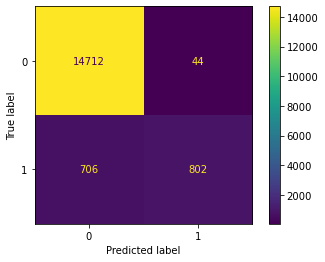

In [151]:
ConfusionMatrixDisplay.from_estimator(randomized_rf_classifier, data_test, labels_test)
plt.show()

This grid search takes sooo much time. Couldn't wait to finish it.  
Anyway, I doubt it will give us much better results.

## Conclusions:

- Good accuracy score: 95%
- Mediocre F1 score (Low Precision)
- Low scoring (False Positive) is mostly due insufficient data to predict Fraudsters. The only thing that is contributing is the time of merchant registration